# Прогнозирование ухода клиента

Цель проекта: создать инструмент, который поможет прогнозировать, что пользователь планирует уйти, для того чтобы своевремнно предложить ему промокоды и специальные условия. 

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.


## Чтение файлов с данными и изучение общей информации.

In [1]:
#Импорт библиотек 
import numpy as np 
import pandas as pd 

#библиотеки для визулизации.
import os
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline
import seaborn as sns
import itertools
#import warnings
#warnings.filterwarnings("ignore")
import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import os
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline
py.init_notebook_mode(connected=True)

#библиотеки для машинного обучения и расчета метрик качества
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm
#from lightgbm import LGBMClassifier
#для подготовки к машинному обучению
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

import statsmodels.api as sm
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV #для поиска гиперпараметров
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from sklearn.pipeline import Pipeline

#для вывода результата всех операций ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy import stats as st
from scipy.stats import levene

In [2]:
# Ввод данных в датафрейм пандас

#contract = pd.read_csv('.../final_provider/contract.csv')

#internet = pd.read_csv('.../final_provider/internet.csv')

#personal = pd.read_csv('.../final_provider/personal.csv')

#phone = pd.read_csv('.../final_provider/phone.csv')

#Назначение имени датафреймов
contract.name = 'contract'
internet.name = 'internet'
personal.name = 'personal'
phone.name = 'phone'

In [3]:
# функция для изучения информации о таблицах в удобном формате
def df_info_describe(df):
    print('Таблица:', df.name)
    print ("Строк:",df.shape[0])
    print ("Столбцов: " ,df.shape[1])
    print ("Список признаков: " ,df.columns.tolist())
    print('')
    print(df.sample(10))
    print (80*'_')
    print ("Уникальные наблюдения: ",df.nunique())
    print (80*'=')
    print ("Мода: ",df.mode())
    print (80*'=')
    print ('Дубликатов в таблице')
    print('')
    print(df.duplicated().sum())
    print('')
    print ('Столбцы с наибольшим количеством пропусков')
    print (80*'_')
    print(df.isna().sum().sort_values(ascending=False).head(20))
    print (80*'_')
    print('')
    print('Всего пропусков в таблице')
    nan_sum = df.isna().sum()
    total_nan = pd.Series(nan_sum).sum()
    print (total_nan) 
    print (80*'_')
    print('')
    print ('Информация о таблице')
    print (80*'_')
    print(df.info())
    print (80*'_')
    print('')
    print ('Описание количественных переменных')
    print (80*'_')
    print(df.describe(percentiles=[.25,.5,.75, .9]))
    print ('')
    print (80*'*')
    print ('')
    
df_info_describe(contract)
print ('')

df_info_describe(internet)
df_info_describe(personal)
df_info_describe(phone)


Таблица: contract
Строк: 7043
Столбцов:  8
Список признаков:  ['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

      customerID   BeginDate              EndDate            Type  \
1186  7670-ZBPOQ  2015-04-01                   No        One year   
5838  9822-BIIGN  2015-09-01                   No  Month-to-month   
65    5122-CYFXA  2019-11-01                   No  Month-to-month   
3306  9643-AVVWI  2019-11-01                   No  Month-to-month   
2881  4003-OCTMP  2017-07-01                   No        One year   
6307  3043-SUDUA  2017-06-01                   No  Month-to-month   
903   5285-MVEHD  2015-06-01                   No        One year   
4332  4194-FJARJ  2015-08-01                   No        Two year   
5310  6171-ZTVYB  2016-07-01                   No  Month-to-month   
1976  9497-QCMMS  2019-12-01  2020-01-01 00:00:00  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCh

Вывод

Количество наблюдений в файле "personal" и "contract" одинаковое - 7043, вероятно, у каждого клиента хотя бы один контракт заключен, количество наблюдений в файле "internet " - 5517, в файле "phone" -6361. Возможно не у всех клиентов, есть телефон и интернет.
Необходимо настроить типы данных для некоторых столбцов.

Таблица  contract содержит информацию о датах начала и конца пользования сервисом, наличии бумажных чеков, способе оплаты, ежемесячной и общей оплате. Столбец type содержит информацию вероятно о типе контракта или оплаты (помесячно, на один год, на два года)

Таблица internet содержит информацию об интернет соединении и доп услугах.
В типе соединения возможны два варианта: фиброоптическое волокно и DSL. 

Волоконно-оптические кабели используют небольшие стеклянные волокна для передачи данных с использованием импульсов света.

DSL — это технология, которая позволяет передавать цифровые данные по проводам телефонной сети.  


In [4]:
# Создание признака ухода клиента выполняется на этом этапе, 
# так как позже значения "No" будут заменены на дату окончания сбора данных 
# для корректного преобразования типа данных в дату.
def list_comp(df):
    return df.assign(churn=['0' if x == 'No' else '1' for x in df['EndDate']])
contract = list_comp(contract)

## Предобработка

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
churn               7043 non-null object
dtypes: float64(1), object(8)
memory usage: 495.3+ KB


In [6]:
# Замена  типа данных на float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'],errors='coerce')
contract['MonthlyCharges'] = pd.to_numeric(contract['MonthlyCharges'],errors='coerce')

# Замена  типа данных на datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

# Замена  в EndDate (чтобы избежать ошибки "unknown string format" при преобразовании типа данных)
contract['EndDate'] = contract['EndDate'].replace('No','2020-02-01')

# Замена  типа данных 
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

#Расчет периода обслуживания клиента
contract['LoyaltyTime'] = contract['EndDate'] - contract['BeginDate']

#Заполнение пропущенных строк в Total Charges
contract['TotalCharges'] = np.where(contract['TotalCharges'].isna() , contract['MonthlyCharges'], contract['TotalCharges'])

In [7]:
#Временное! создание признаков месяца по счету
#Признаки выбраны для предварительного анализа и поиска аномалий с целью исключения таких строк из трейна
# Для избежания утечки таргета эти признаки будут удалены перед обучением модели, чтобы не забыть помечу их меткой 
#***del 
contract['Begin_year'] = contract['BeginDate'].dt.year
contract['Begin_month'] = contract['BeginDate'].dt.month
contract['End_month'] = contract['EndDate'].dt.month
contract ['is_client'] = (contract['EndDate'] - contract['BeginDate']).dt.days // 30


Уточнение по времени жизни клиента, времени лояльности.
Так как в таблице нет дней, а их число высчитывается логически по алгоритму автоматом по количеству дней в фигурирующих месяцах, вполне возможно, что нет смысла считать время "жизни" в днях. Поэтому как вариант этот показатель посчитан в месяцах в столбце 'is_client', но при обучении каждой из моделей для избежания мультиколинеарности будет использован только один из вариантов.
Также перед обучением необходимо удалить будет столбцы Begin_year, Begin_month, End_month, EndDate  BeginDate один из столбцов is_client/LoyaltyTime(***del).

Также как дополнительный вариант по набору признаков можно бужет проанализировать целесообразность использования в трейне датафрейма без TotalCharges.

In [8]:
contract.head(3)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   

      PaymentMethod  MonthlyCharges  TotalCharges churn LoyaltyTime  \
0  Electronic check           29.85         29.85     0     31 days   
1      Mailed check           56.95       1889.50     0   1036 days   
2      Mailed check           53.85        108.15     1     61 days   

   Begin_year  Begin_month  End_month  is_client  
0        2020            1          2          1  
1        2017            4          2         34  
2        2019           10         12          2

In [9]:
contract.shape

#Проверка наличия NaN значений
contract.isna().sum()

(7043, 14)

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
churn               0
LoyaltyTime         0
Begin_year          0
Begin_month         0
End_month           0
is_client           0
dtype: int64

In [10]:
# Соединение датафрэймов в один
from functools import reduce; 
telcom = reduce(lambda left,right: pd.merge(left, right, on='customerID', how='left'), [contract,personal, internet,phone])

#Проверка наличия пропусков в новом датафрейиме
telcom.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
churn                  0
LoyaltyTime            0
Begin_year             0
Begin_month            0
End_month              0
is_client              0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Из 1526 клиентов, у которых есть пропушенные значения в столбце Internet service, 1184 не имеют несколько телефонных линий и только 342 клиента имеют несколько линий, нельзя исключить, что у этих клиентов подключен только телефон, но нет интернета, кроме того все клиенты из датафрэйма phone подключены к интернету через dsl, что означает, что они имеют хотя бы одну телефоную линию. Поэтому заполним пропущенные значения "No".
Но сначала мы сможем использовать пропуски в MultipleLines, чтобы косвенно предположительно судить о наличии телефона.

In [11]:
telcom['phone'] = telcom ['MultipleLines']
def list_comp_phone(df):
    return df.assign(phone=['1' if x == 'Yes' or x == 'No' else '0' for x in df['MultipleLines']])
telcom = list_comp_phone(telcom)
#telcom 

telcom.query('phone == "1"')



customerID  BeginDate    EndDate            Type PaperlessBilling  \
1     5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
5     9305-CDSKC 2019-03-01 2019-11-01  Month-to-month              Yes   
6     1452-KIOVK 2018-04-01 2020-02-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7037  2569-WGERO 2014-02-01 2020-02-01        Two year              Yes   
7038  6840-RESVB 2018-02-01 2020-02-01        One year              Yes   
7039  2234-XADUH 2014-02-01 2020-02-01        One year              Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01 2020-02-01        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges churn  \
1                  Mailed check           56.95       1889.50     0   
2                  Mailed check           53.85        108.15     1   
4              Electronic check           70.70        151.65     1   
5              Electronic check           99.65        820.50     1   
6       Credit card (automatic)           89.10       1949.40     0   
...                         ...             ...           ...   ...   
7037  Bank transfer (automatic)           21.15       1419.40     0   
7038               Mailed check           84.80       1990.50     0   
7039    Credit card (automatic)          103.20       7362.90     0   
7041               Mailed check           74.40        306.60     1   
7042  Bank transfer (automatic)          105.65       6844.50     0   

     LoyaltyTime  ...  Dependents  InternetService  OnlineSecurity  \
1      1036 days  ...          No              DSL             Yes   
2        61 days  ...          No              DSL             Yes   
4        61 days  ...          No      Fiber optic              No   
5       245 days  ...          No      Fiber optic              No   
6       671 days  ...         Yes      Fiber optic              No   
...          ...  ...         ...              ...             ...   
7037   2191 days  ...          No              NaN             NaN   
7038    730 days  ...         Yes              DSL             Yes   
7039   2191 days  ...         Yes      Fiber optic              No   
7041    123 days  ...          No      Fiber optic              No   
7042   2010 days  ...          No      Fiber optic             Yes   

      OnlineBackup DeviceProtection  TechSupport StreamingTV StreamingMovies  \
1               No              Yes           No          No              No   
2              Yes               No           No          No              No   
4               No               No           No          No              No   
5               No              Yes           No         Yes             Yes   
6              Yes               No           No         Yes              No   
...            ...              ...          ...         ...             ...   
7037           NaN              NaN          NaN         NaN             NaN   
7038            No              Yes          Yes         Yes             Yes   
7039           Yes              Yes           No         Yes             Yes   
7041            No               No           No          No              No   
7042            No              Yes          Yes         Yes             Yes   

     MultipleLines phone  
1               No     1  
2               No     1  
4               No     1  
5              Yes     1  
6              Yes     1  
...            ...   ...  
7037            No     1  
7038           Yes     1  
7039           Yes     1  
7041           Yes     1  
7042            No     1  

[6361 rows x 27 columns]

In [12]:
telcom['internet'] = telcom['InternetService']
def list_comp_internet(df):
    return df.assign(internet=['1' if x == 'DSL' or x == 'Fiber optic' else '0' for x in df['InternetService']])
telcom = list_comp_internet(telcom)
print (telcom.query('internet == "1"').head(5))

   customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges churn LoyaltyTime  \
0           Electronic check           29.85         29.85     0     31 days   
1               Mailed check           56.95       1889.50     0   1036 days   
2               Mailed check           53.85        108.15     1     61 days   
3  Bank transfer (automatic)           42.30       1840.75     0   1371 days   
4           Electronic check           70.70        151.65     1     61 days   

   ...  InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0  ...     

In [13]:
telcom = telcom.fillna('No')

In [14]:
# Проверка на совпадение клиентов, у которых есть пропуски и в датафрэйме initernet и в этих же строках в датафрейме phone
multipleLines_a = telcom[telcom.MultipleLines.isna()]
internetservice_b = telcom[telcom.InternetService.isna()]
len(list(set(multipleLines_a.index).intersection(internetservice_b.index)))

0

In [15]:
# проверка количества клиентов с пропушеными значениями в internet service в MultipleLines
telcom[telcom.InternetService.isna()]['MultipleLines'].value_counts()

Series([], Name: MultipleLines, dtype: int64)

In [16]:
# Замена  типа данных для срока 
telcom['LoyaltyTime'] = telcom['LoyaltyTime'] / pd.to_timedelta(1, unit='D')

In [17]:
# Повторная проверка пропущенных значений
telcom.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
churn               0
LoyaltyTime         0
Begin_year          0
Begin_month         0
End_month           0
is_client           0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
phone               0
internet            0
dtype: int64

## Исследовательский анализ данных. Подготовка и общая оценка

### Создание функций для статистического анализа и визуализации

In [18]:
# Функция для построения гистограмм по факту ухода
def hist_churn_(data, column, title):
    (data
     .groupby('churn')[column]
     .plot
     .hist(bins=20, alpha=0.4, normed=True, figsize=(8,6), fontsize=15)
    )
    plt.legend(fontsize=15)
    plt.title(title, fontsize=15, color='b');


# Функция для построения боксплотов по факту ухода
def box_churn(data, column, title):
    data.boxplot(by='churn', column=column, figsize=(8,6), fontsize=15)
    plt.title(title, fontsize=15, color='b');

In [19]:
# Функция для проверки p-value
    
def ttest_independ(df1, df2):
    alpha = 0.05
    results = st.ttest_ind(df1, df2)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу, p-value:", results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу,  p-value:", results.pvalue)



In [20]:
# Функция для проверки p-value,  если дисперсии не равны, 
# с указанием этого с помощью equal_var = False
    
def ttest_independ_eq_false(df1, df2):
    alpha = 0.05
    results = st.ttest_ind(df1, df2, equal_var = False)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу, p-value:", results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу,  p-value:", results.pvalue)



### Подготовка к анализу


#### Настройка типов данных

In [21]:
telcom['internet'] = pd.to_numeric(telcom['internet'],errors='coerce')
telcom['phone'] = pd.to_numeric(telcom['phone'],errors='coerce')
#telcom['churn'] = pd.to_numeric(telcom['churn'],errors='coerce')

#### Разделение столбцов по типу данных и создание таблиц для ушедших и оставшихся клиентов

In [22]:
churn     = telcom[telcom["churn"] == "1"] #ушедшие
not_churn = telcom[telcom["churn"] == "0"] #не ушедшие

##Разделение на количественные и категориальные признаки
Id_col     = ['customerID']
target_col = ["churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

#### Визуализация с помощью графиков

In [23]:
# Уникальные значения 
lab = telcom["churn"].value_counts().keys().tolist()
#Все значения 
val = telcom["churn"].value_counts().values.tolist()

#Соотношение ушедших и оставшихся клиентов 

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'blue','red'],
                             line = dict(color = "white",
                                         width =  1.2)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Cоотношение ушедших и оставшихся клиентов ",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

In [24]:
telcom['MultipleLines'].value_counts()

No     4072
Yes    2971
Name: MultipleLines, dtype: int64

In [25]:
telcom['phone'].value_counts()

1    6361
0     682
Name: phone, dtype: int64

In [26]:
#Функция построения графиков для категориальных признаков
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Not churn customers" 
                   )


    layout = go.Layout(dict(title = column + " Distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "Churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Not churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)




#Цикл применения для всех категориальных признаков
for i in cat_cols :
    plot_pie(i)

In [27]:
#Функция построения графиков для количественных признаков
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    

#Цикл для всех численных признаков   
for i in num_cols :
    histogram(i)

Наибольшее число ушедших клиентов среди новых клиентов, которые менее долго пользуются сервисом и которые успели внести меньшую оплату.

Выявлено, что между ушедшими и оставшимися есть заметные при анализе графиков отличия по типу договора, наличию и типу интернета, размерам платежей и др признакам. Можно более детально проанализировать каждый из признаков и сделать статистичсекую проверку гипотез. Но предварительно оценим данные на предмет аномалий в определнные промежутки времени.

### Месяцы, время пользования

Анализ с целью выявления аномальных периодов и исключения соответсвующих строк из трейна. При этом, если такие периоды будут выявлены, будет сохранен еще один вариант таблицы для создания еще одного варианта трейна, чтобы можно было сравнить метрики.

Количество ушедших и оставшихся с учетом месяца начала без учета года, чел


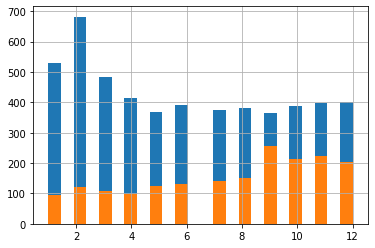

In [28]:
print ('Количество ушедших и оставшихся с учетом месяца начала без учета года, чел')
telcom.groupby('churn')['Begin_month'].hist(bins=24);


При анализе графика видно, что доля выбывших высокая у подключившихся с 9 по 12 месяцы. Можно попробовать для большей точности взять срез за какой-то год и посмотреть картину в нем. Но сначала получим список годов в выборке и сделаем анализ ухода по годам.

In [29]:
print ("Уникальные наблюдения, год подключения : ",contract['Begin_year'].unique())

Уникальные наблюдения, год подключения :  [2020 2017 2019 2016 2018 2014 2015 2013]


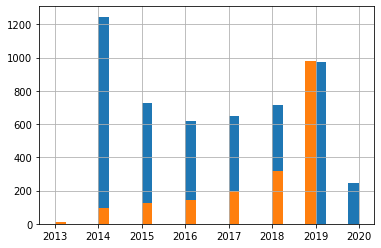

In [30]:
telcom.groupby('churn')['Begin_year'].hist(bins=24);

Согласно графику наибольшие число и доля оставшихся подключились в 2014 году. Число оставшихся велико и среди подключившихся в 2019 году, но ушедших было так же много, поэтому доля в данном случае будет около 50%, т.е. в 2019 году также было много новых клиентов, но число и доля ушедших максимально велики.
Теперь сделаем анализ по месяцам для разных лет.

In [31]:
telcom14=telcom.query('Begin_year == "2014"')

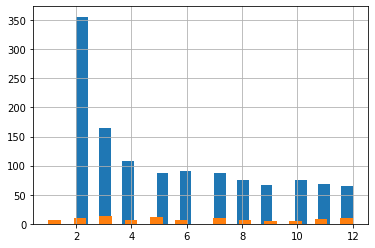

In [32]:
telcom14.groupby('churn')['Begin_month'].hist(bins=24);

In [33]:
del telcom14

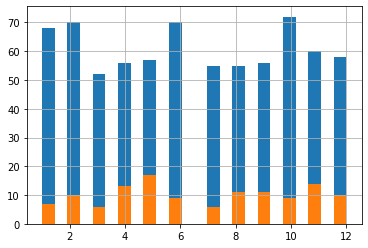

In [34]:
telcom15=telcom.query('Begin_year == "2015"')
telcom15.groupby('churn')['Begin_month'].hist(bins=24);

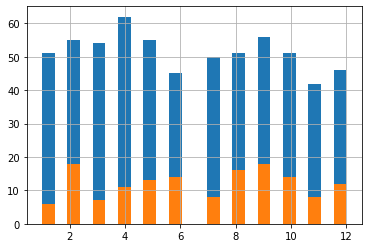

In [35]:
del telcom15
telcom16=telcom.query('Begin_year == "2016"')
telcom16.groupby('churn')['Begin_month'].hist(bins=24);

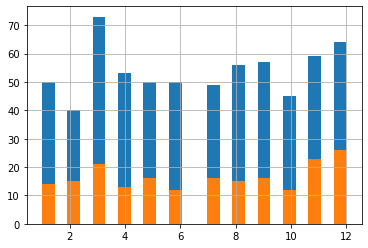

In [36]:
del telcom16
telcom17=telcom.query('Begin_year == "2017"')
telcom17.groupby('churn')['Begin_month'].hist(bins=24);

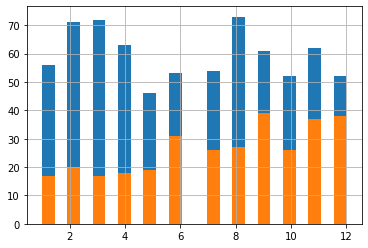

In [37]:
del telcom17
telcom18=telcom.query('Begin_year == "2018"')
telcom18.groupby('churn')['Begin_month'].hist(bins=24);

Пришедших в 2019 году: 1957
Из них выбывших: 981


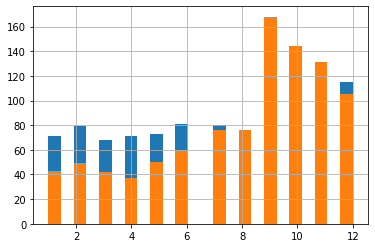

In [38]:
del telcom18
telcom19=telcom.query('Begin_year == "2019"')
print('Пришедших в 2019 году:', len(telcom19))
telcom19_churn=telcom19.query('churn == "1"')
print('Из них выбывших:', len(telcom19_churn)) 
telcom19.groupby('churn')['Begin_month'].hist(bins=24);

Согласно графику среди подключившихся в августе-ноябре 2019 года были только те клиенты, которые ушли.
Возможно это связано со сбоем в сборе данных в этот период или с крайне неудачной акцией или негативной антирекламной компанией или техническими неполадками в этот период, возможно имело место перезаключение договоров, можно попробовать поискать полные дубликаты без учета дат регистрации, чтобы найти перерегистрированных формально клиентов. В любом случае был какой-то дополнительный признак не отраженный вероятно в таблице, причина ухода или "ухода" пользователей и данные за эти месяцы могут ухудшать точность прогноза и имеет смысл их исключить, а также сделать повторный анализ данных после их исключения. Можно использовать для этих целей фильтр df[new_col] = 0
df.loc[filter, new_col] = 1 или сделаем это с помощью срезов и индексации по условию.


In [39]:
telcom_new_19 = telcom.query('Begin_year == "2019"')


In [40]:
telcom_new_19 = telcom.query('Begin_year == "2019"')
telcom_new_19.loc[telcom_new_19['Begin_month'] ==7, 'col_del'] = "1"
telcom_new_19.loc[telcom_new_19['Begin_month'] ==8, 'col_del'] = "1"
telcom_new_19.loc[telcom_new_19['Begin_month'] ==9, 'col_del'] = "1"
telcom_new_19.loc[telcom_new_19['Begin_month'] ==10, 'col_del'] = "1"
telcom_new_19.loc[telcom_new_19['Begin_month'] ==11, 'col_del'] = "1"
telcom_new_19.loc[telcom_new_19['Begin_month'] ==12, 'col_del'] = "1"
telcom_new_19['col_del'] = telcom_new_19['col_del'].fillna('0')
#telcom['col_del5'].fillna('0')
telcom['col_del'] = telcom_new_19['col_del']
telcom['col_del'] = telcom['col_del'].fillna('0')

In [41]:
telcom_new_19

customerID  BeginDate    EndDate            Type PaperlessBilling  \
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
5     9305-CDSKC 2019-03-01 2019-11-01  Month-to-month              Yes   
7     6713-OKOMC 2019-04-01 2020-02-01  Month-to-month               No   
10    9763-GRSKD 2019-01-01 2020-02-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7030  0871-OPBXW 2019-12-01 2020-02-01  Month-to-month              Yes   
7032  6894-LFHLY 2019-10-01 2019-11-01  Month-to-month              Yes   
7036  7750-EYXWZ 2019-02-01 2020-02-01        One year               No   
7040  4801-JZAZL 2019-03-01 2020-02-01  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month              Yes   

         PaymentMethod  MonthlyCharges  TotalCharges churn  LoyaltyTime  ...  \
2         Mailed check           53.85        108.15     1         61.0  ...   
4     Electronic check           70.70        151.65     1         61.0  ...   
5     Electronic check           99.65        820.50     1        245.0  ...   
7         Mailed check           29.75        301.90     0        306.0  ...   
10        Mailed check           49.95        587.45     0        396.0  ...   
...                ...             ...           ...   ...          ...  ...   
7030      Mailed check           20.05         39.25     0         62.0  ...   
7032  Electronic check           75.75         75.75     1         31.0  ...   
7036  Electronic check           60.65        743.30     0        365.0  ...   
7040  Electronic check           29.60        346.45     0        337.0  ...   
7041      Mailed check           74.40        306.60     1        123.0  ...   

      OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport StreamingTV  \
2                Yes           Yes                No           No          No   
4                 No            No                No           No          No   
5                 No            No               Yes           No         Yes   
7                Yes            No                No           No          No   
10               Yes            No                No           No          No   
...              ...           ...               ...          ...         ...   
7030              No            No                No           No          No   
7032              No            No                No           No          No   
7036              No           Yes               Yes          Yes         Yes   
7040             Yes            No                No           No          No   
7041              No            No                No           No          No   

      StreamingMovies MultipleLines phone internet col_del  
2                  No            No     1        1       1  
4                  No            No     1        1       1  
5                 Yes           Yes     1        1       0  
7                  No            No     0        1       0  
10                 No            No     1        1       0  
...               ...           ...   ...      ...     ...  
7030               No            No     1        0       1  
7032               No           Yes     1        1       1  
7036              Yes            No     0        1       0  
7040               No            No     0        1       0  
7041               No           Yes     1        1       1  

[1957 rows x 29 columns]

In [42]:
telcom_new_19_churn = telcom_new_19.query('churn == "1"')
telcom_new_19_churn['churn']

2       1
4       1
5       1
18      1
20      1
       ..
7011    1
7018    1
7026    1
7032    1
7041    1
Name: churn, Length: 981, dtype: object

In [43]:
telcom_new_19_churn

customerID  BeginDate    EndDate            Type PaperlessBilling  \
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
5     9305-CDSKC 2019-03-01 2019-11-01  Month-to-month              Yes   
18    4190-MFLUW 2019-01-01 2019-11-01  Month-to-month               No   
20    8779-QRDMV 2019-11-01 2019-12-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7011  5482-NUPNA 2019-06-01 2019-10-01  Month-to-month              Yes   
7018  1122-JWTJW 2019-10-01 2019-11-01  Month-to-month              Yes   
7026  8775-CEBBJ 2019-02-01 2019-11-01  Month-to-month              Yes   
7032  6894-LFHLY 2019-10-01 2019-11-01  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges churn  \
2                  Mailed check           53.85        108.15     1   
4              Electronic check           70.70        151.65     1   
5              Electronic check           99.65        820.50     1   
18      Credit card (automatic)           55.20        528.35     1   
20             Electronic check           39.65         39.65     1   
...                         ...             ...           ...   ...   
7011               Mailed check           60.40        272.15     1   
7018               Mailed check           70.65         70.65     1   
7026  Bank transfer (automatic)           44.20        403.35     1   
7032           Electronic check           75.75         75.75     1   
7041               Mailed check           74.40        306.60     1   

      LoyaltyTime  ...  OnlineSecurity  OnlineBackup  DeviceProtection  \
2            61.0  ...             Yes           Yes                No   
4            61.0  ...              No            No                No   
5           245.0  ...              No            No               Yes   
18          304.0  ...              No            No               Yes   
20           30.0  ...              No            No               Yes   
...           ...  ...             ...           ...               ...   
7011        122.0  ...             Yes           Yes                No   
7018         31.0  ...              No            No                No   
7026        273.0  ...              No            No                No   
7032         31.0  ...              No            No                No   
7041        123.0  ...              No            No                No   

      TechSupport StreamingTV  StreamingMovies MultipleLines phone internet  \
2              No          No               No            No     1        1   
4              No          No               No            No     1        1   
5              No         Yes              Yes           Yes     1        1   
18            Yes          No               No            No     1        1   
20             No          No              Yes            No     0        1   
...           ...         ...              ...           ...   ...      ...   
7011          Yes          No               No            No     1        1   
7018           No          No               No            No     1        1   
7026           No          No               No            No     1        1   
7032           No          No               No           Yes     1        1   
7041           No          No               No           Yes     1        1   

     col_del  
2          1  
4          1  
5          0  
18         0  
20         1  
...      ...  
7011       0  
7018       1  
7026       0  
7032       1  
7041       1  

[981 rows x 29 columns]

In [44]:
telcom['col_del']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: col_del, Length: 7043, dtype: object

Чтобы оценить насколько значим вклад ушедшиих в эти месяцы в общую картину посчитаем их долю среди всех ушедших

In [45]:
# в этой таблице все пользователи подключившиеся в июль-декабрь 2019 года
telcom_new_19_all_churn_month = telcom_new_19_churn.query('col_del == "1"')
print ('Число ушедших, подключившихся в июле-ноябре 2019:', len(telcom_new_19_all_churn_month))
print ('Всего ушедших:', len(telcom.query('churn == "1"')))
print ('Доля выбывших, подключившихся в эти даты от всех выбывших:', len(telcom_new_19_all_churn_month) / len(telcom.query('churn == "1"')))

Число ушедших, подключившихся в июле-ноябре 2019: 700
Всего ушедших: 1869
Доля выбывших, подключившихся в эти даты от всех выбывших: 0.37453183520599254


Получается, что из 7042 клиентов с 2013 по 2020 год ушли 1869, и более чем треть из них - это клиенты которые, которые подключились в июле-ноябре 2019 года. Попытаемся предположить, с чем это может быть связано. Но естественно что для более точного анализа еще необходимы будут дополнительные сведения.


In [46]:
#сохраняю таблицу без строк с клиентами с датой начала в 7-12 месяцах 2019, 
#далее в тексте будем называть этой выборкой1(или выборкой "2019-"")
telcom_clean = telcom.query('col_del == "0"')
telcom_clean_churn = telcom_clean.query('churn == "1"')
#telcom_no_churn19 = telcom_no_churn19.drop('col_del', axis = 1)

In [47]:
#telcom_new_19.query('Begin_year == "2019" and col_del = "1"')['Begin_month'].value_counts() 

In [48]:
#проверяю, какие значения месяца для 2019 года попали в таблицу
telcom_clean.query('Begin_year == "2019"')['Begin_month'].value_counts() 

6    141
2    128
5    123
1    114
3    110
4    108
Name: Begin_month, dtype: int64

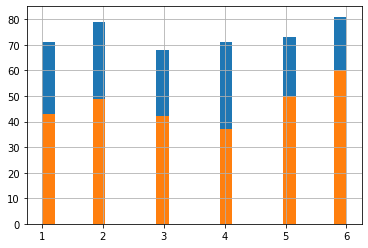

In [49]:
telcom1_19 = telcom_clean.query('Begin_year == "2019"')
telcom1_19.groupby('churn')['Begin_month'].hist(bins=24);

In [50]:
telcom['End_month'].value_counts()

2     5174
11     485
12     466
1      460
10     458
Name: End_month, dtype: int64

Среди месяцев ухода встречаются только январь, февраль, октябрь, ноябрь, декабрь 

## Исследовательский анализ данных. Анализ отдельных групп

Сравним для каждой группы долю выбывших клиентов с долей выбывших в общей группе, если доля выбывших в какой-то группе выше, чем во всей выборке, то этот признак можно будет учесть при предсказании ухода клиента, но необходимо провести анализ на предмет опосредованной связи с каким-то другим признаком имеющимся в таблице, а также можно оценить долю клиентов каждой группы среди всех и среди выбывших. Если среди выбывших доля клиентов какой-то группы выше, чем в общей выборке, то это также можно учесть (второй показатель уже представлен ранее в круговых диаграммах выше при оценке категориальных признаков).

### Тип договора

In [51]:
print ('Из 1869 выбывших клиентов всей выборки помесячная плата была у:', len(churn.query('Type == "Month-to-month"')))
print ('Среди 1869 выбывших клиентов доля клиентов с помесячным договором', len(churn.query('Type == "Month-to-month"'))/1869)

Из 1869 выбывших клиентов всей выборки помесячная плата была у: 1655
Среди 1869 выбывших клиентов доля клиентов с помесячным договором 0.8855002675227395


Т.е. только 12% выбывших клиентов имели не помесячный договор.
Проверим а сколько клиентов из тех, что имели помесячны договор выбили.

In [52]:
month_to = telcom.query('Type == "Month-to-month"')
len_month_to = len(month_to)
len_data = len(contract)
month_to_churn = month_to.query('churn == "1"')
print ('Всего клиентов', len_data)
print ('Клиентов с помесячным договром', len_month_to)
print ('Всего выбывших клиентов', len(telcom.query('churn == "1"')))
print ('Доля клиентов с помесячным договором среди всех', len_month_to/len_data)
print ('Среди клиентов с помесячным договором выбывших', len(month_to.query('churn == "1"')))
print ('Доля клиентов с помесячным договром среди выбывших', len(month_to.query('churn == "1"'))/len(telcom.query('churn == "1"')))
print ('Доля выбывших среди клиентов с помесячным договором', len (month_to_churn)/len_month_to)                                                         


Всего клиентов 7043
Клиентов с помесячным договром 3875
Всего выбывших клиентов 1869
Доля клиентов с помесячным договором среди всех 0.5501916796819537
Среди клиентов с помесячным договором выбывших 1655
Доля клиентов с помесячным договром среди выбывших 0.8855002675227395
Доля выбывших среди клиентов с помесячным договором 0.4270967741935484


Доля выбывших среди клиентов с помесячным договром 0.42, что выше, чем во всей выборке. Также важно, что доля клиентов с помесячным договром среди выбывших 0.88. Но так как среди всех клиентов 55% с помесячным договором, то сложно будет использовать этот показатель как моно, все же нужно будет учитывать совокупность признаков.

 ### Анализ пользователей интернета

#### Клиенты с фиброволокном

Фиброволокно. Мода 0    74.4
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f261d1df1d0>]],
      dtype=object)

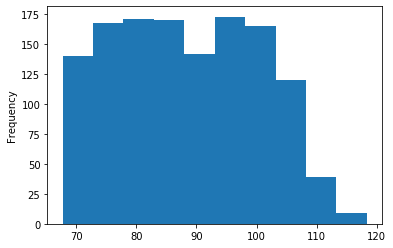

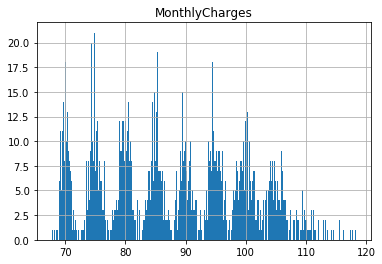

In [53]:
fiber_churn = churn.query('InternetService == "Fiber optic"')
print('Фиброволокно. Мода', fiber_churn['MonthlyCharges'].mode())
fiber_churn['MonthlyCharges'].plot(kind='hist')

fiber_churn.hist(column='MonthlyCharges', bins=300)

In [54]:
fiber_churn['MonthlyCharges'].describe()


count    1297.000000
mean       88.126484
std        11.882834
min        67.750000
25%        78.800000
50%        87.550000
75%        98.400000
max       118.350000
Name: MonthlyCharges, dtype: float64

Таблицы и графики выше отражают, какие именно ежемесячные платежи у выбывших пользователей с фиброволокном. Сначала были сомнения, что такое распределение возможно в реале и данные не синтетические, потому что на каждые 5 единиц есть пик, общая картина складывается как бы из множества графиков с нормальным распределением. Не исключено, что в реале это могло получиться, так как много тарифов, активации на неполный месяц, если платежи округляют при каком-то самом часто используемом способе оплаты? например, до 5 рублей (хотя наверное все же причина в самих тарифах... потому что стабильно снижается число сильно после каждого пика)

Если это реальные данные и пики связаны с тарифами, то для фиброволкна 9 тарифов получается...
Тогда тут проблема в том, что почти одинаково на всех тарифах клиенты выбывают по частоте и нет смылса платежи в этой группе внутри неё как-то дифференцировать в контексте задачи. 
Но на этом графике примечательно, что диапазоне от 70 до 110 число клиентов наибольшее. Вероятно, самый дешевый тариф с фиброволокном начинается от 70 единиц.
Изучим срок пользования интеренетом у этих клиентов.

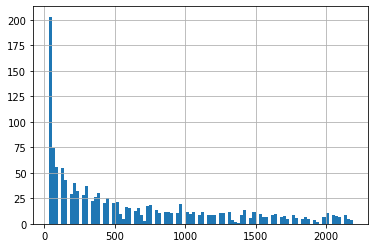

In [55]:
fiber_churn['LoyaltyTime'].hist(bins=100)

In [56]:
#fiber_churn 
fiber_all = telcom.query('InternetService == "Fiber optic"')
all = len(contract) 
all_clean = len(telcom) 
all_churn = len(churn) 
part_churn = len(churn)/len(contract)
print ('Всего клиентов', all)
print ('Всего ушедших', all_churn)
print ('Доля выбывших клиентов среди всех', part_churn)
print ('Всего клиентов с фиброволокном', len(fiber_all))
print ('Выбывших клиентов с фиброволокном', len(fiber_churn))
print ('Доля выбывших клиентов среди клиентов с фиброволокном', len(fiber_churn)/len(fiber_all))

print ('Отличие от доли выбывших во всей выборке', (part_churn - len(fiber_churn)/len(fiber_all)))



Всего клиентов 7043
Всего ушедших 1869
Доля выбывших клиентов среди всех 0.2653698707936959
Всего клиентов с фиброволокном 3096
Выбывших клиентов с фиброволокном 1297
Доля выбывших клиентов среди клиентов с фиброволокном 0.4189276485788114
Отличие от доли выбывших во всей выборке -0.15355777778511548


В целом клиенты с фиброволокном более склонны к уходу по сравнению со всей выборкой в целом.
При анализе таблицы по выбывшим клиентам с фиброволкном обратили на себя внимание клиенты с помесячным договором. Проверим эту группу и сравним с общей выборкой.

In [57]:
print ('Из 1297 выбывших клиентов с фиброволокном помесячный договор был у:', len(fiber_churn.query('Type == "Month-to-month"')))
print ('Доля клиентов с помесячным договором среди всех', len_month_to/len_data)
print ('Доля клиентов с помесячным договром среди выбывших', len(month_to.query('churn == "1"'))/len(telcom.query('churn == "1"')))

print ('Доля клиентов с помесячным договором среди выбывших с фиброволокном ', len(fiber_churn.query('Type == "Month-to-month"'))/1297)
len_fiber__month_churn = len(fiber_churn.query('Type == "Month-to-month"'))
len_fiber_month=len(telcom.query('Type == "Month-to-month" and InternetService == "Fiber optic"'))
print ('Доля ушедших с фиброволокном и помесячным договором')
print ('по отношению ко всем клиентам с фиброволокном и помесячным договором',len_fiber__month_churn/len_fiber_month)

Из 1297 выбывших клиентов с фиброволокном помесячный договор был у: 1162
Доля клиентов с помесячным договором среди всех 0.5501916796819537
Доля клиентов с помесячным договром среди выбывших 0.8855002675227395
Доля клиентов с помесячным договором среди выбывших с фиброволокном  0.8959136468774094
Доля ушедших с фиброволокном и помесячным договором
по отношению ко всем клиентам с фиброволокном и помесячным договором 0.5460526315789473


#### Клиенты с DSL

DSL. Мода 0    45.3
dtype: float64


count    459.000000
mean      49.083224
std       13.608829
min       23.450000
25%       42.125000
50%       49.250000
75%       55.675000
max       92.450000
Name: MonthlyCharges, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f261dc8bb90>]],
      dtype=object)

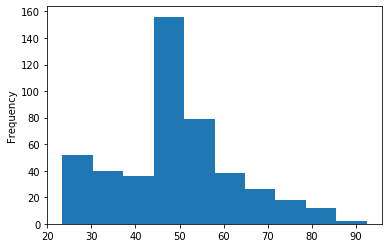

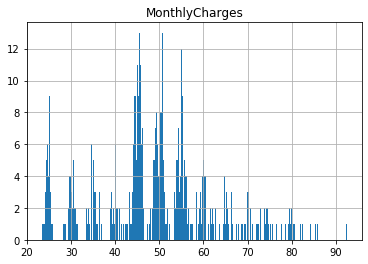

In [58]:
dsl_churn = churn.query('InternetService == "DSL"')
print('DSL. Мода', dsl_churn['MonthlyCharges'].mode())
dsl_churn['MonthlyCharges'].plot(kind='hist')
dsl_churn['MonthlyCharges'].describe()
dsl_churn.hist(column='MonthlyCharges', bins=300)

Среди пользователей DSL в целом более низкие платежи (от 20 до 90, в отличие от 70-120 у клиентов с фиброволкном) и много выбывших с малыми платежами. В целом распределние выбывших похоже на нормальное с пиком около 50 единиц, если смотреть при небольшой детализации, за исключение пиков на малых суммах около 25 и 35 единиц. Но при более детальном рассмотрении также есть
окло 10 пиков.
Здесь прослеживается все же тенденция к увеличению числа отказавшихся в диапазоне 45 до 55.
Возможно отказавшиеся пользователи с низкой платой были на самом деле недовльны не ценой (25-35), а качеством обслуживания, например низкая скорость или неудобство DSL или отсутвием каких-то доп функций.
Изучим подробнее этих пользователей.


In [59]:
dsl_churn_cheap37 = dsl_churn.query('MonthlyCharges < 37')
print (dsl_churn_cheap37.head(20))
dsl_churn_cheap37

      customerID  BeginDate    EndDate            Type PaperlessBilling  \
27    8665-UTDHZ 2019-11-01 2019-12-01  Month-to-month               No   
133   3091-FYHKI 2019-12-01 2020-01-01  Month-to-month              Yes   
180   6317-YPKDH 2019-12-01 2020-01-01  Month-to-month               No   
185   1024-GUALD 2019-10-01 2019-11-01  Month-to-month              Yes   
272   6366-ZGQGL 2019-11-01 2019-12-01  Month-to-month               No   
358   9057-MSWCO 2017-10-01 2020-01-01  Month-to-month               No   
498   6235-VDHOM 2019-07-01 2019-12-01  Month-to-month               No   
610   6543-CPZMK 2019-02-01 2019-11-01  Month-to-month              Yes   
660   5650-VDUDS 2019-08-01 2019-12-01  Month-to-month              Yes   
677   0822-GAVAP 2019-10-01 2019-12-01  Month-to-month              Yes   
893   9227-LUNBG 2019-10-01 2019-11-01  Month-to-month               No   
973   8919-FYFQZ 2016-02-01 2019-10-01  Month-to-month              Yes   
1144  0841-NULXI 2019-10-

customerID  BeginDate    EndDate            Type PaperlessBilling  \
27    8665-UTDHZ 2019-11-01 2019-12-01  Month-to-month               No   
133   3091-FYHKI 2019-12-01 2020-01-01  Month-to-month              Yes   
180   6317-YPKDH 2019-12-01 2020-01-01  Month-to-month               No   
185   1024-GUALD 2019-10-01 2019-11-01  Month-to-month              Yes   
272   6366-ZGQGL 2019-11-01 2019-12-01  Month-to-month               No   
...          ...        ...        ...             ...              ...   
6810  7758-XKCBS 2018-08-01 2019-11-01  Month-to-month              Yes   
6864  5480-HPRRX 2019-10-01 2020-01-01  Month-to-month               No   
6884  7384-GHBPI 2019-08-01 2019-11-01  Month-to-month              Yes   
6943  0032-PGELS 2019-10-01 2019-11-01  Month-to-month               No   
6999  2108-XWMPY 2019-07-01 2019-10-01  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges churn  \
27             Electronic check           30.20         30.20     1   
133            Electronic check           35.45         35.45     1   
180   Bank transfer (automatic)           29.95         29.95     1   
185            Electronic check           24.80         24.80     1   
272   Bank transfer (automatic)           24.80         24.80     1   
...                         ...             ...           ...   ...   
6810           Electronic check           29.70        438.25     1   
6864           Electronic check           25.30         77.75     1   
6884           Electronic check           35.15         99.75     1   
6943  Bank transfer (automatic)           30.50         30.50     1   
6999               Mailed check           35.45        106.85     1   

      LoyaltyTime  ...  InternetService  OnlineSecurity  OnlineBackup  \
27           30.0  ...              DSL              No           Yes   
133          31.0  ...              DSL              No            No   
180          31.0  ...              DSL              No           Yes   
185          31.0  ...              DSL              No            No   
272          30.0  ...              DSL              No            No   
...           ...  ...              ...             ...           ...   
6810        457.0  ...              DSL              No            No   
6864         92.0  ...              DSL              No            No   
6884         92.0  ...              DSL              No            No   
6943         31.0  ...              DSL             Yes            No   
6999         92.0  ...              DSL             Yes           Yes   

      DeviceProtection TechSupport  StreamingTV StreamingMovies MultipleLines  \
27                  No          No           No              No            No   
133                 No          No           No             Yes            No   
180                 No          No           No              No            No   
185                 No          No           No              No            No   
272                 No          No           No              No            No   
...                ...         ...          ...             ...           ...   
6810                No         Yes           No              No            No   
6864                No          No           No              No            No   
6884                No          No           No             Yes            No   
6943                No          No           No              No            No   
6999                No          No           No              No            No   

     phone internet  
27       0        1  
133      0        1  
180      0        1  
185      0        1  
272      0        1  
...    ...      ...  
6810     0        1  
6864     0        1  
6884     0        1  
6943     0        1  
6999     0        1  

[92 rows x 28 columns]

Пользователей DSL с низкой платой до 37 единиц было обнаружено 92. При беглом осомтре бросается в глаза, что часто у них договор был помесячный и часто встречается способ оплаты Electronic check и Mailed check. Как мы помним этот тип договора и эти способы оплаты чаще встречались среди выбывших, чем другие. Можно проверить тогда оценить с помощью поверки гипотез разницу в группах.

Сравнение можно провести как в общей выборке так и вподгруппах по ведущим признакам (напримр по месячным платежам).


Интересно посмотреть, какая продолжительность использования интернета у этих клиентов .

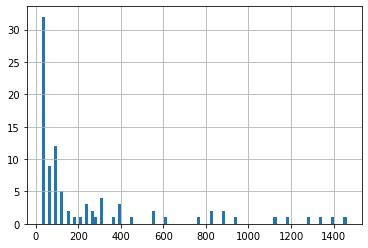

In [60]:
dsl_churn_cheap37['LoyaltyTime'].hist(bins=100)

Много выбывших на раннем сроке. Изучим подробнее, сколько именно и кто это.

In [61]:
print ('Выбывших через месяц с дешевым DSL:', len(dsl_churn_cheap37.query('LoyaltyTime <35 ')))


Выбывших через месяц с дешевым DSL: 32


In [62]:
dsl_churn_cheap37.query('LoyaltyTime <35 ')

customerID  BeginDate    EndDate            Type PaperlessBilling  \
27    8665-UTDHZ 2019-11-01 2019-12-01  Month-to-month               No   
133   3091-FYHKI 2019-12-01 2020-01-01  Month-to-month              Yes   
180   6317-YPKDH 2019-12-01 2020-01-01  Month-to-month               No   
185   1024-GUALD 2019-10-01 2019-11-01  Month-to-month              Yes   
272   6366-ZGQGL 2019-11-01 2019-12-01  Month-to-month               No   
893   9227-LUNBG 2019-10-01 2019-11-01  Month-to-month               No   
1144  0841-NULXI 2019-10-01 2019-11-01  Month-to-month              Yes   
1161  5868-CZJDR 2019-12-01 2020-01-01  Month-to-month              Yes   
1334  1768-ZAIFU 2019-11-01 2019-12-01  Month-to-month              Yes   
1513  0661-XEYAN 2019-09-01 2019-10-01  Month-to-month              Yes   
1694  0375-HVGXO 2019-11-01 2019-12-01  Month-to-month              Yes   
2295  2672-DZUOY 2019-11-01 2019-12-01  Month-to-month              Yes   
2427  7854-FOKSF 2019-12-01 2020-01-01  Month-to-month               No   
2465  1740-CSDJP 2019-12-01 2020-01-01  Month-to-month              Yes   
3092  6032-IGALN 2019-10-01 2019-11-01  Month-to-month              Yes   
3185  9907-SWKKF 2019-10-01 2019-11-01  Month-to-month               No   
3652  0612-RTZZA 2019-11-01 2019-12-01  Month-to-month               No   
3756  9136-ALYBR 2019-09-01 2019-10-01  Month-to-month              Yes   
3773  8260-NGFNY 2019-09-01 2019-10-01  Month-to-month               No   
3983  1334-FJSVR 2019-10-01 2019-11-01  Month-to-month              Yes   
4396  0023-HGHWL 2019-10-01 2019-11-01  Month-to-month              Yes   
4424  4729-XKASR 2019-09-01 2019-10-01  Month-to-month               No   
4924  5378-IKEEG 2019-10-01 2019-11-01  Month-to-month              Yes   
5186  3776-EKTKM 2019-09-01 2019-10-01  Month-to-month              Yes   
5411  7932-WPTDS 2019-10-01 2019-11-01  Month-to-month              Yes   
6074  3797-VTIDR 2019-11-01 2019-12-01  Month-to-month              Yes   
6080  9526-BIHHD 2019-10-01 2019-11-01  Month-to-month               No   
6219  1496-GGSUK 2019-12-01 2020-01-01  Month-to-month              Yes   
6256  3751-KTZEL 2019-09-01 2019-10-01  Month-to-month               No   
6509  0616-ATFGB 2019-09-01 2019-10-01  Month-to-month               No   
6607  7242-QZLXF 2019-12-01 2020-01-01  Month-to-month              Yes   
6943  0032-PGELS 2019-10-01 2019-11-01  Month-to-month               No   

                  PaymentMethod  MonthlyCharges  TotalCharges churn  \
27             Electronic check           30.20         30.20     1   
133            Electronic check           35.45         35.45     1   
180   Bank transfer (automatic)           29.95         29.95     1   
185            Electronic check           24.80         24.80     1   
272   Bank transfer (automatic)           24.80         24.80     1   
893            Electronic check           24.60         24.60     1   
1144           Electronic check           35.55         35.55     1   
1161               Mailed check           31.35         31.35     1   
1334           Electronic check           25.20         25.20     1   
1513               Mailed check           25.80         25.80     1   
1694           Electronic check           34.70         34.70     1   
2295           Electronic check           25.15         25.15     1   
2427           Electronic check           35.90         35.90     1   
2465  Bank transfer (automatic)           35.25         35.25     1   
3092               Mailed check           25.10         25.10     1   
3185               Mailed check           25.05         25.05     1   
3652           Electronic check           25.25         25.25     1   
3756               Mailed check           24.45         24.45     1   
3773               Mailed check           25.20         25.20     1   
3983           Electronic check           24.25         24.25     1   
4396           Electronic check        

Треть из выбывших с дешевым DSL отключились через месяц использования

In [63]:
telcom.pivot_table('MonthlyCharges', index='InternetService', columns='churn')

churn                    0          1
InternetService                      
DSL              60.212105  49.083224
Fiber optic      93.932379  88.126484
No               21.136058  20.368142

In [64]:
dsl = telcom.query('InternetService == "DSL"')
dsl_churn = churn.query('InternetService == "DSL"')
dsl_churn_cheap33 = dsl_churn.query('MonthlyCharges < 33')
dsl_churn_cheap30 = dsl_churn.query('MonthlyCharges < 30')
dsl_churn_cheap_43_57 = dsl_churn.query('MonthlyCharges < 30')
dsl_month = dsl.query('Type == "Month-to-month"')
dsl_churn_month = dsl_churn.query('Type == "Month-to-month"')
dsl_cheap37 = dsl.query('MonthlyCharges < 37')
dsl_cheap33 = dsl.query('MonthlyCharges < 33')
dsl_cheap30 = dsl.query('MonthlyCharges < 30')
dsl_cheap_43_57 = dsl.query('MonthlyCharges < 30')

In [65]:
print ('Доля выбывших среди клиентов с DSL', len (churn.query('InternetService == "DSL"'))/len(telcom.query('InternetService == "DSL"'))) 
print ('Доля выбывших среди клиентов с DSL и помесячным договором', len(dsl_churn_month)/len(dsl_month))
print ('Доля выбывших среди клиентов с DSL и низкими платежами до 37', len(dsl_churn_cheap37)/len(dsl_cheap37))
print ('Доля выбывших среди клиентов с DSL и низкими платежами до 33', len(dsl_churn_cheap33)/len(dsl_cheap33))
print ('Доля выбывших среди клиентов с DSL и низкими платежами до 30', len(dsl_churn_cheap30)/len(dsl_cheap30))
print ('Доля выбывших среди клиентов с DSL и платежами от 43 до 57', len(dsl_churn_cheap_43_57)/len(dsl_cheap_43_57))

Доля выбывших среди клиентов с DSL 0.1895910780669145
Доля выбывших среди клиентов с DSL и помесячным договором 0.3221586263286999
Доля выбывших среди клиентов с DSL и низкими платежами до 37 0.34328358208955223
Доля выбывших среди клиентов с DSL и низкими платежами до 33 0.38414634146341464
Доля выбывших среди клиентов с DSL и низкими платежами до 30 0.3858267716535433
Доля выбывших среди клиентов с DSL и платежами от 43 до 57 0.3858267716535433


Возможно в целом среди клиентов с DSL много старых лояльных клиентов. Но клиенты с помесячным договором и/или низкими платежами менее лояльны. Нужно более глубоко проанализировать целесообразность продолжать делать такие подключения. Возможно качество настолько неудобовримое, что нужно предлагать не скидки и акции, а изначально предлагать другой сервис этим клиентам. Для более точного ответа необходим более глубокий анализ, особенно клиентов с DSL и платежами до 30 рублей и от 43 до 57 рублей. 


In [66]:
print ('Доля выбывших среди всех клиентов',len(telcom.query('churn == "1"'))/len(telcom))
print ('Доля выбывших среди клиентов с фибровлокном', len(fiber_churn)/len(fiber_all))
print ('Доля выбывших среди клиентов с помесячным догвором', len(month_to.query('churn == "1"'))/len(month_to))
print ('Доля выбывших среди клиентов с фиброволкном и помесячным договором',len_fiber__month_churn/len_fiber_month)

Доля выбывших среди всех клиентов 0.2653698707936959
Доля выбывших среди клиентов с фибровлокном 0.4189276485788114
Доля выбывших среди клиентов с помесячным догвором 0.4270967741935484
Доля выбывших среди клиентов с фиброволкном и помесячным договором 0.5460526315789473


Согласно этим результатам клиенты с DSL более лояльны при предварительно грубом аналиизе. Но возможжно среди них много старых клиентов(например давно подключенные организации и компании) и если бы мы исключили их из выборки и оценивлаи отдельно частных клиентов, то анализ был бы более информативным и прогноз более точным.
Можно рекомендовать сделать анализ отдельно для организаций и отдельно физ лиц.

 ### Аналииз общих и месячных платежей

#### Месячные платежи

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



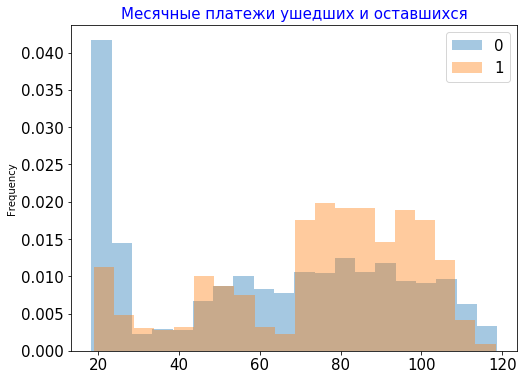

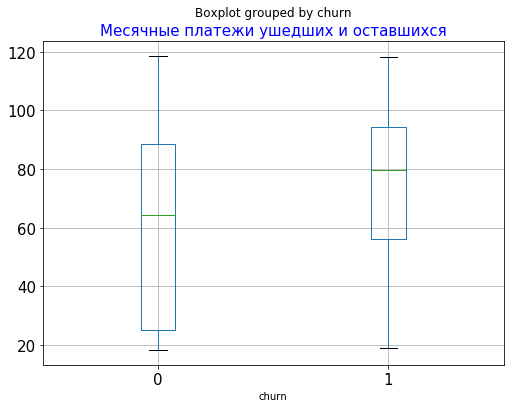

In [67]:
hist_churn_(telcom, 'MonthlyCharges', 'Месячные платежи ушедших и оставшихся');
box_churn (telcom, 'MonthlyCharges', 'Месячные платежи ушедших и оставшихся');

count       mean        std    min    25%     50%    75%  \
departed        1869.0  74.441332  24.666053  18.85  56.15  79.650  94.20   
remaining       5174.0  61.265124  31.092648  18.25  25.10  64.425  88.40   
MonthlyCharges  7043.0  64.761692  30.090047  18.25  35.50  70.350  89.85   

                   max  
departed        118.35  
remaining       118.75  
MonthlyCharges  118.75

Text(0.5, 1.0, 'Сумма в месяц')

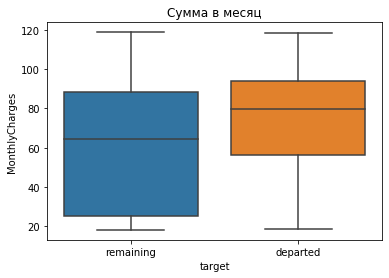

In [68]:
#Чтобы отразить рядом два боксплота по платежам для наглядности
#использую снова исходную таблицу с данными по контрактам 
#(видимо в ходе работы со сводной таблицей telcom были сделаны 
#преобразования из-за которых не получается из неё сделать такие боксплоты)
contract1 = pd.read_csv('/datasets/final_provider/contract.csv')
contract1['target'] = np.where(contract1['EndDate']=='No', 'remaining', 'departed')
pd.concat([contract1.groupby('target')['MonthlyCharges'].agg('describe'),contract1['MonthlyCharges'].agg('describe').to_frame().T])
ax = sns.boxplot(data=contract1, x='target',y='MonthlyCharges')
ax.set_title('Сумма в месяц')

Имеется группа с самыми выскоими платежами, среди которых очень мало отказавшихся. Нужно проанализировать возможные причины: 

а)обеспечнные клиенты подключились давно и не хотят тратить время на смену оператора (в пользу этого говорит характер распределения, постепенное снижение числа отказавшися по мере роста платежей от 100 до 120)

б)среди клиентов с такой большое платой есть сотрудники компании на каком-то старом тарифе, которые на самом деле не платят фактически эту сумму, а она идет им бонусом в общем пакете оплаты

в)есть какой-то набор услуг, выгодный для абонентов, за который они готовы платить такую плату (выгодное для клиентов соотношение цена - качества). Наибольший пик числа оставшихся был у клииентов с платой около 114 и 115 рублей. Можно более внимательно проанализировать эту группу. 

Ну и вполне логично что среди клиентов с совсем низкой месячной платой мало отказавшихся, это клиенты с платой до 26 единиц.

Также более детально проанализируем пики отказов. Такиех клиентов также много в группе с небольшими платежами. Вероятно это связано с тем, что таких клиентов в принципе больше. Скорее всего это вновь привлеченные клиенты, которые так и не втянулись в использование сервиса.
Также вероятно есть группы с более выскими платежами за какие-то не очень нужные клиентам доп услуги.


In [69]:
telcom.groupby('churn')[['MonthlyCharges']].mean() 

MonthlyCharges
churn                
0           61.265124
1           74.441332

Платежи в месяц, руб


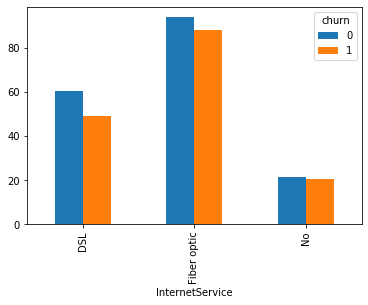

In [70]:
telcom.pivot_table('MonthlyCharges', index='InternetService', columns='churn').plot(kind='bar')
print('Платежи в месяц, руб')


In [71]:
# Расчет медианы, среднего, стандартного отклонения, дисперсии 
telcom.pivot_table('MonthlyCharges', index=['InternetService',], columns='churn',aggfunc=['median','mean','var','std'])
   




median              mean                    var              \
churn                0      1          0          1           0           1   
InternetService                                                               
DSL              59.75  49.25  60.212105  49.083224  259.504597  185.200231   
Fiber optic      94.80  87.55  93.932379  88.126484  160.116416  141.201750   
No               20.15  20.00  21.136058  20.368142    4.846647    2.122413   

                       std             
churn                    0          1  
InternetService                        
DSL              16.109146  13.608829  
Fiber optic      12.653712  11.882834  
No                2.201510   1.456851

In [72]:
telcom.pivot_table('MonthlyCharges', index='InternetService', columns='churn')

churn                    0          1
InternetService                      
DSL              60.212105  49.083224
Fiber optic      93.932379  88.126484
No               21.136058  20.368142

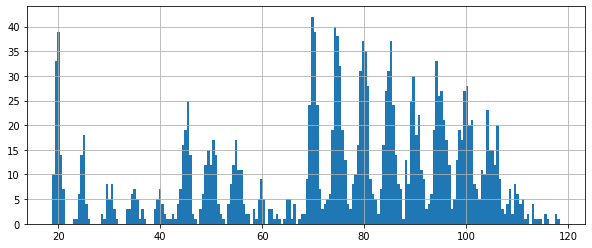

In [73]:
churn['MonthlyCharges'].hist(bins=200,  figsize=(10,4)); 

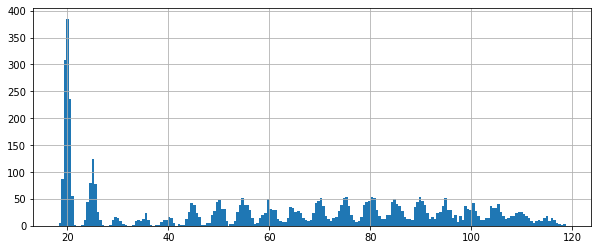

In [74]:
not_churn['MonthlyCharges'].hist(bins=200,  figsize=(10,4)); 

In [75]:
telcom.pivot_table('MonthlyCharges', index='churn',)

MonthlyCharges
churn                
0           61.265124
1           74.441332

In [76]:
monthly_all = telcom['MonthlyCharges']
monthly_churn = churn['MonthlyCharges']
monthly_not_churn = not_churn['MonthlyCharges']
total_churn = churn['TotalCharges']
total_not_churn = not_churn['TotalCharges']
total_all=telcom['TotalCharges']

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Месячные платежи


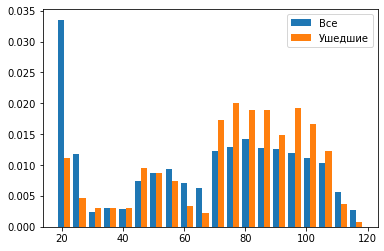

In [77]:
plt.hist([monthly_all, monthly_churn], label=['Все', 'Ушедшие'], 
         bins=20, density=True)
plt.legend(loc='best')
print ('Месячные платежи');

Месячные платежи


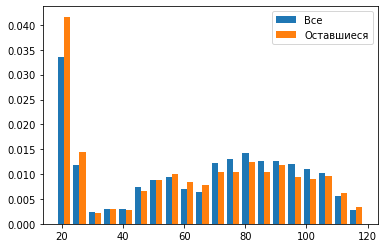

In [78]:
plt.hist([monthly_all, monthly_not_churn], label=['Все', 'Оставшиеся'], 
         bins=20, density=True)
plt.legend(loc='best')
print ('Месячные платежи');

Месячные платежи


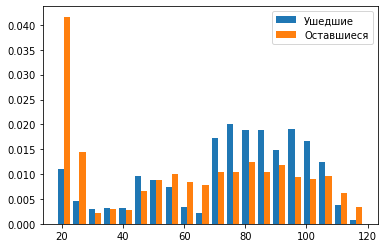

In [79]:
plt.hist([monthly_churn, monthly_not_churn], label=['Ушедшие', 'Оставшиеся'], 
         bins=20, density=True)
plt.legend(loc='best')
print ('Месячные платежи');

Месячные платежи


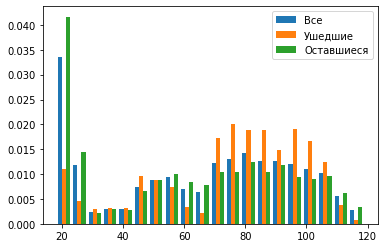

In [80]:
plt.hist([monthly_all, monthly_churn, monthly_not_churn], label=['Все','Ушедшие','Оставшиеся'], 
         bins=20, density=True)
plt.legend(loc='best')
print ('Месячные платежи');

In [81]:
telcom.pivot_table('MonthlyCharges', index='InternetService', columns='churn')

churn                    0          1
InternetService                      
DSL              60.212105  49.083224
Fiber optic      93.932379  88.126484
No               21.136058  20.368142

Платежи в месяц, руб


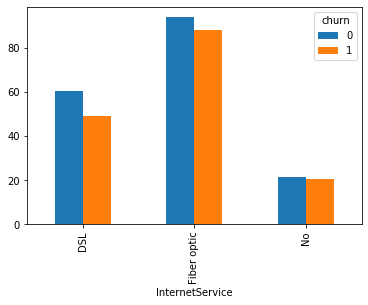

In [82]:
telcom.pivot_table('MonthlyCharges', index='InternetService', columns='churn').plot(kind='bar')
print('Платежи в месяц, руб')

##### Проверка гипотез о месячных платежах

Нулевая гипотеза: Месячные платежи ушедших равны месячным платежам оставшихся

Алтернативная гипотеза: Месячные платежи ушедших не равны месячным платежам оставшихся

Нулевая гипотеза Н0: monthly_churn = monthly_not_churn 

Альтернативная гипотеза Н1:  monthly_churn != monthly_not_churn 

In [83]:
(telcom
 .pivot_table(index='churn', values=['MonthlyCharges'], 
              aggfunc=['median','mean','var','std'])
  .round()
)

median           mean            var            std
      MonthlyCharges MonthlyCharges MonthlyCharges MonthlyCharges
churn                                                            
0               64.0           61.0          967.0           31.0
1               80.0           74.0          608.0           25.0

In [84]:
dispers_monthly_churn = np.var(monthly_churn)
dispers_monthly_not_churn = np.var(monthly_not_churn)

print ('Дисперсия месячных платежей ушедших', dispers_monthly_churn)
print ('Дисперсия размера выручки от пользователей тарифа Ультра', dispers_monthly_not_churn)

Дисперсия месячных платежей ушедших 608.0886541373271
Дисперсия размера выручки от пользователей тарифа Ультра 966.5659188385843


Если бы разница была менее явной можно было бы оценить с помощью scipy.stats.levene

In [85]:
#Если считать дисперсии равными
ttest_independ(monthly_churn, monthly_not_churn)

Отвергаем нулевую гипотезу, p-value: 2.706645606888261e-60


In [86]:
#Если считать дисперсии неравными
ttest_independ_eq_false(monthly_churn, monthly_not_churn)

Отвергаем нулевую гипотезу, p-value: 8.592449331547539e-73


При любой оценкке дисперсии отвегаем нулевую гипотезу о том, что  месячные платежи ушедших равны месячным платежам оставшихся,
alpha = 0.05, p-value: 8.592449331547539e-73


In [87]:
# Рассчитаем средние месячные платежи среди ушедщих и оставшихся
print('Средние месячные платежи среди ушедщих:', monthly_churn.mean().round(), 'единиц')
print('Средние месячные платежи среди оставшихся:', monthly_not_churn.mean().round(), 'единиц')

Средние месячные платежи среди ушедщих: 74.0 единиц
Средние месячные платежи среди оставшихся: 61.0 единиц


#### Общие платежи

In [88]:
telcom.groupby('churn')[['TotalCharges']].mean()

TotalCharges
churn              
0       2549.999497
1       1531.796094

Общие платежи


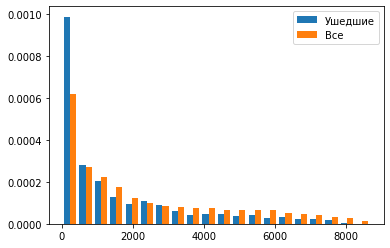

In [89]:
print ('Общие платежи')
plt.hist([total_churn, total_all], label=['Ушедшие', 'Все'], 
         bins=20, density=True)
plt.legend(loc='best');



Общие платежи


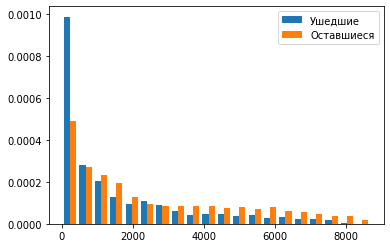

In [90]:
print ('Общие платежи')
plt.hist([total_churn, total_not_churn], label=['Ушедшие', 'Оставшиеся'], 
         bins=20, density=True)
plt.legend(loc='best');



В группе с нулевыми общими платежами ушедших больше (видимо это люди подключившие услугу, но не начавшие её использовать).

Можно посмотреть по временным рядам, есть ли приуроченность этих людей к определнным датам, возможно акциям какми-то. 

Если есть, то можно сравнить  пользоватлей, которые подключались в эти даты оставшихся и ушедших ни разу и не заплативших. А также отследить, сколько все же оставлись из подключившихся в эти даты. Тогда в будущем можно будет расчитать выгодность проведения таких акций (какой доход был получен от подключенных пользователей и какой был расход на их подключение), а также разработать выгодные условия, чтобы больше клиентов оставалось.


In [91]:
telcom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 29 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
churn               7043 non-null object
LoyaltyTime         7043 non-null float64
Begin_year          7043 non-null int64
Begin_month         7043 non-null int64
End_month           7043 non-null int64
is_client           7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection  

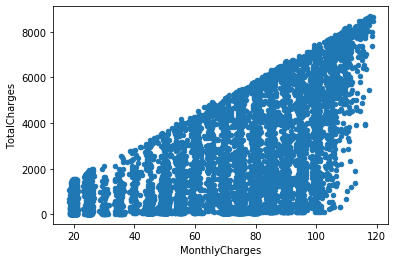

In [92]:
#Скаттер плот 
telcom[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',
                                                              y='TotalCharges')

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Monthly Charges')

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

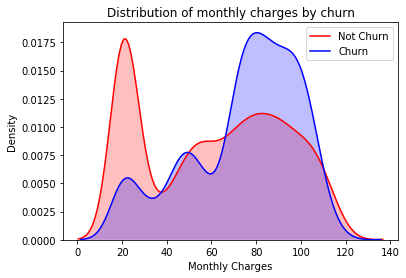

In [93]:
ax = sns.kdeplot(telcom.MonthlyCharges[(telcom["churn"] == '0') ],
                color="Red", shade = True)
ax = sns.kdeplot(telcom.MonthlyCharges[(telcom["churn"] == '1') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

### По подключенным сервисам

Text(0.5, 1.0, 'phone')

Text(0.5, 1.0, 'MultipleLines')

Text(0.5, 1.0, 'InternetService')

Text(0.5, 1.0, 'OnlineSecurity')

Text(0.5, 1.0, 'OnlineBackup')

Text(0.5, 1.0, 'DeviceProtection')

Text(0.5, 1.0, 'TechSupport')

Text(0.5, 1.0, 'StreamingTV')

Text(0.5, 1.0, 'StreamingMovies')

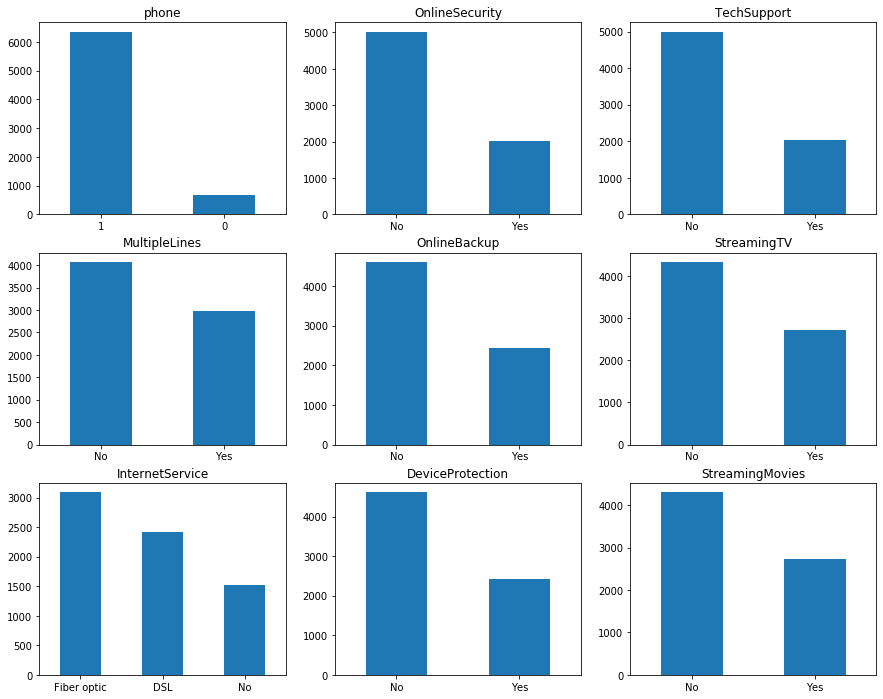

In [94]:
services = ['phone','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = telcom[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = telcom[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = telcom[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

Как мы помним из предварительного анализа среди ушедших доля пользователей почти для всех доп сервисов, кроме стрим тв и фильмов выше, чем среди оставшихся.
Разлчиия были небольшими поэтому для большей точности можно сделать стат проверку, но на предварительном этапе можно предположить, что значимость всех сервисов кроме тв и фильмов для большинства небольшая, а платить за неё многие люди не хотят и в целом недовольны размером платы, поэтому уходят к другим провайдерам.
Или возможно просто среди новых клиентов сколнных к уходу больше подключившихся с этой фунцией и 
Нужно оценить долю ушедших среди пользоватлей этой функции и другие харктеристики.

## Обработка данных для обучения моделей на всей выборке.

In [95]:
telcom['col_del'] = telcom['col_del'].astype('int')

In [96]:
telcom = telcom.drop(['BeginDate','EndDate','Begin_year','Begin_month','End_month','LoyaltyTime'], axis = 1)
df__for_CatBoost = telcom.copy() 


In [97]:
telcom.columns.tolist()

['customerID',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'churn',
 'is_client',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'phone',
 'internet',
 'col_del']

In [98]:
#выборки без некоторых столбцов
telcom_no_total_charges = telcom.drop('TotalCharges', axis = 1)
telcom_less_col = telcom_no_total_charges.drop(['gender','Partner','MultipleLines','internet', 'phone'], axis = 1)
telecom_less_no_col_del = telcom_less_col.drop(['col_del'], axis = 1)

In [99]:
#id 
Id_col     = ['customerID']
#Таргет
target_col = ['churn']
#Бинарные признаки (да, нет)
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()

In [100]:
#Категориальные признаки
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]

In [101]:
#Численные признаки
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]


In [102]:
#Признаки с более чем 2 категориями
multi_cols = [i for i in cat_cols if i not in bin_cols]

In [103]:
#Encoding бинарных признаков
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    



In [104]:
#Дублирование категориальных признаков
telcom = pd.get_dummies(data = telcom,columns = multi_cols, drop_first=True)

#Масштабирование численных признаков
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)


In [105]:
#удаление оригинальных признаков и соединение масштабированных признаков 
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

In [106]:
telcom.head(4)

customerID  PaperlessBilling  churn  gender  SeniorCitizen  Partner  \
0  7590-VHVEG                 1      0       0              0        1   
1  5575-GNVDE                 0      0       1              0        0   
2  3668-QPYBK                 1      1       1              0        0   
3  7795-CFOCW                 0      0       1              0        0   

   Dependents  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0           0               0             1                 0  ...   
1           0               1             0                 1  ...   
2           0               1             1                 0  ...   
3           0               1             0                 1  ...   

   Type_One year  Type_Two year  PaymentMethod_Credit card (automatic)  \
0              0              0                                      0   
1              1              0                                      0   
2              0              0                                      0   
3              1              0                                      0   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
0                               1                           0   
1                               0                           1   
2                               0                           1   
3                               0                           0   

   InternetService_Fiber optic  InternetService_No  MonthlyCharges  \
0                            0                   0       -1.160323   
1                            0                   0       -0.259629   
2                            0                   0       -0.362660   
3                            0                   0       -0.746535   

   TotalCharges  is_client  
0     -0.992667  -1.271794  
1     -0.172198   0.059904  
2     -0.958122  -1.231439  
3     -0.193706   0.503804  

[4 rows x 27 columns]

In [107]:
#Оценка связей, корреляций 
correlation = telcom.corr()


In [108]:
correlation

PaperlessBilling     churn    gender  \
PaperlessBilling                               1.000000  0.191825 -0.011754   
churn                                          0.191825  1.000000 -0.008612   
gender                                        -0.011754 -0.008612  1.000000   
SeniorCitizen                                  0.156530  0.150889 -0.001874   
Partner                                       -0.014877 -0.150448 -0.001808   
Dependents                                    -0.111377 -0.164221  0.010517   
OnlineSecurity                                -0.003636 -0.171226 -0.017021   
OnlineBackup                                   0.126735 -0.082255 -0.013773   
DeviceProtection                               0.103797 -0.066160 -0.002105   
TechSupport                                    0.037880 -0.164674 -0.009212   
StreamingTV                                    0.223841  0.063228 -0.008393   
StreamingMovies                                0.211716  0.061382 -0.010487   
MultipleLines                                  0.163530  0.040102 -0.008414   
phone                                          0.016505  0.011942 -0.006488   
internet                                       0.321013  0.227890 -0.006026   
col_del                                        0.002884  0.315460 -0.011482   
Type_One year                                 -0.051391 -0.177820  0.008026   
Type_Two year                                 -0.147889 -0.302253 -0.003695   
PaymentMethod_Credit card (automatic)         -0.013589 -0.134302  0.001215   
PaymentMethod_Electronic check                 0.208865  0.301919  0.000752   
PaymentMethod_Mailed check                    -0.205398 -0.091683  0.013744   
InternetService_Fiber optic                    0.326853  0.308020 -0.011286   
InternetService_No                            -0.321013 -0.227890  0.006026   
MonthlyCharges                                 0.352150  0.193356 -0.014569   
TotalCharges                                   0.158562 -0.198347 -0.000087   
is_client                                      0.006012 -0.351956  0.005240   

                                       SeniorCitizen   Partner  Dependents  \
PaperlessBilling                            0.156530 -0.014877   -0.111377   
churn                                       0.150889 -0.150448   -0.164221   
gender                                     -0.001874 -0.001808    0.010517   
SeniorCitizen                               1.000000  0.016479   -0.211185   
Partner                                     0.016479  1.000000    0.452676   
Dependents                                 -0.211185  0.452676    1.000000   
OnlineSecurity                             -0.038653  0.143106    0.080972   
OnlineBackup                                0.066572  0.141498    0.023671   
DeviceProtection                            0.059428  0.153786    0.013963   
TechSupport                                -0.060625  0.119999    0.063268   
StreamingTV                                 0.105378  0.124666   -0.016558   
StreamingMovies                             0.120176  0.117412   -0.039741   
MultipleLines                               0.142948  0.142057   -0.024526   
phone                                       0.008576  0.017706   -0.001762   
internet                                    0.182742 -0.000615   -0.139812   
col_del                                     0.001088 -0.231464   -0.119401   
Type_One year                              -0.046262  0.082783    0.068368   
Type_Two year                              -0.117000  0.248091    0.204613   
PaymentMethod_Credit card (automatic)      -0.024135  0.082029    0.060267   
PaymentMethod_Electronic check              0.171718 -0.083852   -0.150642   
PaymentMethod_Mailed check                 -0.153477 -0.095125    0.059071   
InternetService_Fiber optic                 0.255338  0.000304   -0.165818   
InternetService_No                         -0.182742  0.000615    0.139812   
MonthlyCharges                   

In [109]:
#Матрица корреляций здесь приведена для всех признаков, ниже будет приведена более корректно выборочно
#только для количественных признаков

matrix_cols = correlation.columns.tolist()

corr_array  = np.array(correlation)

#Построение графика кореляций 
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Матрица корреляций для переменных",
                        autosize = False,
                        height  = 720,
                        width   = 850,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

Но для более корректной проверки корреляций необходмио учитывать только количественные признаки как ниже. Для сочетаний количественных и качественных можно делать проверку гипотез, ниже приведен пример месячных платежей для ушедших и оставшихся.

<Figure size 1440x720 with 0 Axes>

Text(0.5, 1, 'Тепловая карта корреляции по Пирсону')

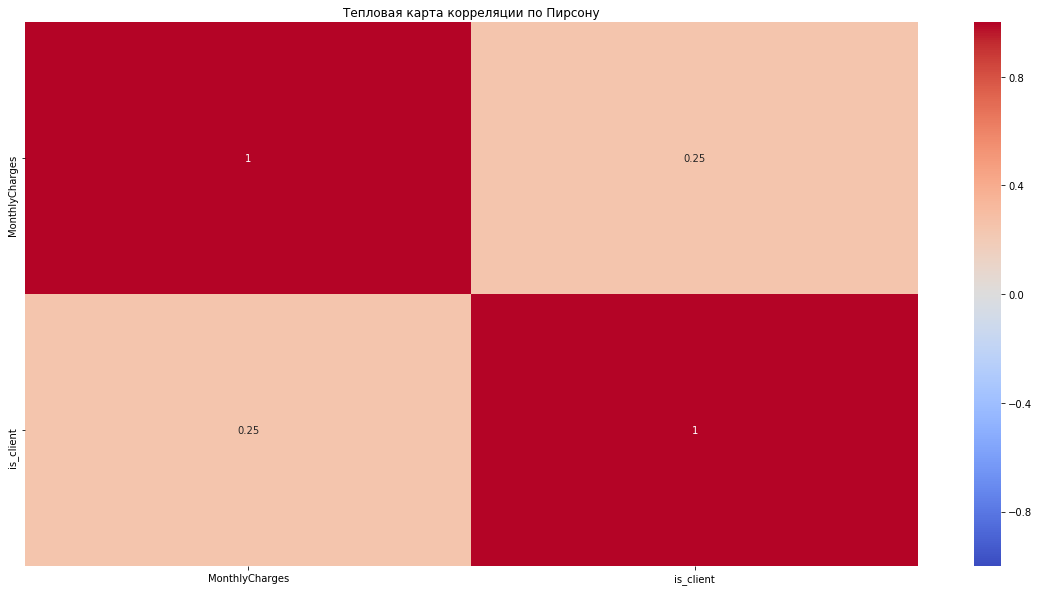

In [110]:
numeric = ['MonthlyCharges', 'is_client']

plt.figure(figsize=(20, 10))
sns.heatmap(telcom[numeric].corr(),
            cmap='coolwarm',
            vmin=-1, vmax=1,
            annot=True)
plt.title('Тепловая карта корреляции по Пирсону')

## Построение моделей обучения с учителем.

In [111]:
X = telcom.drop(['churn','customerID'], 1)
y = telcom['churn']

X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.2, shuffle = False)

X_train, X_valid, y_train, y_valid= train_test_split(X_train, y_train, test_size = 0.25, shuffle = False)

print(X_train.shape, X_test.shape, X_valid.shape)

(4225, 25) (1409, 25) (1409, 25)


In [112]:
pd.set_option('display.max_columns', 150)
X_train.head(4)

PaperlessBilling  gender  SeniorCitizen  Partner  Dependents  \
0                 1       0              0        1           0   
1                 0       1              0        0           0   
2                 1       1              0        0           0   
3                 0       1              0        0           0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0               0             1                 0            0            0   
1               1             0                 1            0            0   
2               1             1                 0            0            0   
3               1             0                 1            1            0   

   StreamingMovies  MultipleLines  phone  internet  col_del  Type_One year  \
0                0              0      0         1        0              0   
1                0              0      1         1        0              1   
2                0              0      1         1        1              0   
3                0              0      0         1        0              1   

   Type_Two year  PaymentMethod_Credit card (automatic)  \
0              0                                      0   
1              0                                      0   
2              0                                      0   
3              0                                      0   

   PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
0                               1                           0   
1                               0                           1   
2                               0                           1   
3                               0                           0   

   InternetService_Fiber optic  InternetService_No  MonthlyCharges  \
0                            0                   0       -1.160323   
1                            0                   0       -0.259629   
2                            0                   0       -0.362660   
3                            0                   0       -0.746535   

   TotalCharges  is_client  
0     -0.992667  -1.271794  
1     -0.172198   0.059904  
2     -0.958122  -1.231439  
3     -0.193706   0.503804

In [113]:
classifiers = [['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()],
               ['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['LogisticRegression :', LogisticRegression()],
               ['CatBoost :', CatBoostClassifier(logging_level='Silent')]
               
              ]

predictions_df = pd.DataFrame()
predictions_df['actual_labels'] = y_valid

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_valid)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_valid, predictions))
    print('Roc_auc score: ', roc_auc_score(y_valid, predictions),'\n')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

DecisionTree : 0.7473385379701917
Roc_auc score:  0.6852878051764657 



/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForest : 0.8190205819730305
Roc_auc score:  0.7171971940843304 



GaussianNB(priors=None, var_smoothing=1e-09)

Naive Bayes : 0.7402413058907026
Roc_auc score:  0.7511151781481161 



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

KNeighbours : 0.7877927608232789
Roc_auc score:  0.7163267178841437 



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression : 0.8005677785663591
Roc_auc score:  0.7094712398741824 



CatBoost : 0.8339247693399574
Roc_auc score:  0.7504384243233736 



Output на всякий случай

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
DecisionTree : 0.758694109297374
Roc_auc score:  0.6971877118838481 

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RandomForest : 0.8076650106458482
Roc_auc score:  0.7094075154085758 

GaussianNB(priors=None, var_smoothing=1e-09)
Naive Bayes : 0.7402413058907026
Roc_auc score:  0.7511151781481161 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
KNeighbours : 0.7877927608232789
Roc_auc score:  0.7163267178841437 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression : 0.8005677785663591
Roc_auc score:  0.7094712398741824 

<catboost.core.CatBoostClassifier at 0x7fc95fc5fc10>
CatBoost : 0.8339247693399574
Roc_auc score:  0.7504384243233736 



In [114]:
# Функция GridSearch поиска гиперпараметров с помощью GridSearch с проверкой на тесте
def search_best_param_test(estimator, params):
    
    model= estimator(random_state=12345)
    
    
    
    model1 = GridSearchCV(model, param_grid=params, n_jobs=-1)
    
    model1.fit(X_train,y_train)
    
    print("Best Hyper Parameters:",model1.best_params_)
    
    prediction=model1.predict(X_test)
      
    print("Accuracy train:",accuracy_score(prediction,y_test))

    print('Roc_auc score train: ', roc_auc_score(y_test, prediction))
    
    print("Confusion Metrix:\n",confusion_matrix(prediction,y_test))
    return model1.best_params_

In [115]:
# Функция валидации результата выбранной модели с выбранными гиперпараметрами   
def churn_prediction(estimator,training_x,validation_x,
                             training_y,validation_y) :
    
   
    estimator.fit(training_x,training_y)  #модель
    predictions   = estimator.predict(validation_x)
    probabilities = estimator.predict_proba(validation_x)
    accuracy = accuracy_score(validation_y,predictions) 
    
    model_roc_auc = roc_auc_score(validation_y,predictions)  #roc_auc_score
    print (estimator)
    print ("\n Classification report : \n",classification_report(validation_y,predictions))
    print ("Accuracy   Score :{:.3f} \n Area under curve :{:.3f}".format(accuracy, model_roc_auc ))
    
    #confusion matrix
    conf_matrix = confusion_matrix(validation_y,predictions)
    
   
    return  accuracy, model_roc_auc


### DecisionTreeClassifier

Долгая ячейка с плохим резултатом... сохранила её аутпут и перевела в маркдаун с тегами для отображения кода
```python
# Поиск гиперпараметров для Decision Tree Clasiffier
params_dt = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
             'max_depth': [10,20,30,50,100,500],
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[12345],
            'class_weight': ['balanced']}

best_dt_params =  search_best_param_test(DecisionTreeClassifier, params_dt)
```

Аутпут готовый для вышестоящей ячейки (очнь плохой результат... хуже константной модели)

Best Hyper Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 12345}
Accuracy train: 0.7615330021291696
Roc_auc score train:  0.7002933607034529
Confusion Metrix:
 [[857 165]
 [171 216]]


### RandomForest

Долгая ячейка с плохим резултатом... сохранила её аутпут и перевела в маркдаун с тегами для отображения кода
```python
#Поиск гипермараметров Random forest Classifier
from  sklearn.ensemble import RandomForestClassifier
params_rfc = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [10,20,30,50,100,500],
              'n_estimators': [10,20,50,100],
              'random_state':[12345],
              'class_weight': ['balanced']}


best_rfc_params =  search_best_param_test(RandomForestClassifier, params_rfc)
```

Аутпут готовый для вышестоящей ячейки
Best Hyper Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 12345}
Accuracy train: 0.8246983676366217
Roc_auc score train:  0.7361477067312111
Confusion Metrix:
 [[955 174]
 [ 73 207]]



### Logistic Regression Classifier


Долгая ячейка с плохим резултатом... сохранила её аутпут и перевела в маркдаун с тегами для отображения кода
```python
#Поиск гипермараметров Logistic Regresion Classifier
params_logit = {
               'max_iter': [10,50,100,500],
               'class_weight': ['balanced'],
               'solver': ['newton-cg', 'liblinear', 'sag', 'saga'], 
               'multi_class':['auto', 'ovr'],
          'random_state':[123]}

best_logit_params =  search_best_param_test(LogisticRegression, params_logit)
```

Аутпут готовый для вышестоящей ячейки

Roc_auc score train: 0.76


Best Hyper Parameters: {'class_weight': 'balanced', 'max_iter': 10, 'multi_class': 'auto', 'random_state': 123, 'solver': 'sag'}
Accuracy train: 0.752306600425834
Roc_auc score train:  0.7616986835789495
Confusion Metrix:
 [[762  83]
 [266 298]]



In [116]:
# Обучение модели с наилучшими гиперпараметрами и вывод результатов для валидацонной выборки 

decisiontreeclassifier_model = DecisionTreeClassifier(random_state = 12345, min_samples_split = 9, min_samples_leaf = 4, max_features = 'log2', 
                           max_depth = 30, class_weight = 'balanced')

logistic_model  = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='auto', n_jobs=1,
          penalty='l2', random_state=12453, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

randomforestclassifier_model = RandomForestClassifier(max_features = 'auto' ,  max_depth =  20  , n_estimators =100 ,
                             random_state = 12345, class_weight = 'balanced' )

NaiveBayes =  GaussianNB()

CatBoost =  CatBoostClassifier(logging_level='Silent')
adaBoost_model  = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate= 1, n_estimators = 1000, random_state = 12345)

models = [decisiontreeclassifier_model,  logistic_model, randomforestclassifier_model,adaBoost_model, CatBoost,  NaiveBayes,]
accuracy_valid =[]
auc_valid = []
for model in models:
    accuracy, auc = churn_prediction(model ,X_train,X_valid,y_train,y_valid)
    accuracy_valid.append(accuracy)
    auc_valid.append(auc)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=30,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.77      0.82      1027
           1       0.53      0.68      0.59       382

    accuracy                           0.75      1409
   macro avg       0.70      0.72      0.70      1409
weighted avg       0.77      0.75      0.76      1409

Accuracy   Score :0.747 
 Area under curve :0.724
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10, multi_class='

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1027
           1       0.76      0.55      0.64       382

    accuracy                           0.83      1409
   macro avg       0.80      0.74      0.76      1409
weighted avg       0.82      0.83      0.82      1409

Accuracy   Score :0.830 
 Area under curve :0.742
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_

In [117]:
# Функция для увеличения выборки, апсемплинга
def function_for_upsampling(features, target, repeat):
    X_zeros = features[target == 0]
    X_ones = features[target == 1]
    y_zeros = target[target == 0]
    y_ones = target[target == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled

#Применение функции увеличения выборки к датафрейму без категориальных признаков
X_upsampled, y_upsampled = function_for_upsampling(X_train, y_train, 10)

In [118]:
accuracy_ups =[]
auc_roc_ups = []

for model in models:
    accuracy_up, auc_up = churn_prediction(model ,X_upsampled,X_valid,y_upsampled,y_valid)
    accuracy_ups.append(accuracy_up)
    auc_roc_ups.append(auc_up)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=30,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1027
           1       0.53      0.65      0.59       382

    accuracy                           0.75      1409
   macro avg       0.70      0.72      0.70      1409
weighted avg       0.77      0.75      0.76      1409

Accuracy   Score :0.751 
 Area under curve :0.719
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10, multi_class='

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      1027
           1       0.64      0.65      0.64       382

    accuracy                           0.80      1409
   macro avg       0.75      0.75      0.75      1409
weighted avg       0.81      0.80      0.80      1409

Accuracy   Score :0.804 
 Area under curve :0.755
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_

Аутпут для Catboost, самой удачной модели Area under curve :0.779

<catboost.core.CatBoostClassifier object at 0x7fc95fe1ea90>

 Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1027
           1       0.54      0.81      0.65       382

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.81      0.76      0.77      1409

Accuracy   Score :0.762 
 Area under curve :0.779

In [119]:
upsampled_metrik = pd.DataFrame(data = [accuracy_ups, auc_roc_ups], index = ['accuracy_ups','auc_ups'],
                                columns =  ['DecisionTreeClassifier','LogisticRegression','RandomForestClassifier', 'adaBoost_model', 'CatBoostClassifier', 'Naive'] ).T
upsampled_metrik

accuracy_ups   auc_ups
DecisionTreeClassifier      0.750887  0.718960
LogisticRegression          0.750887  0.764994
RandomForestClassifier      0.804116  0.754652
adaBoost_model              0.639461  0.718974
CatBoostClassifier          0.762243  0.778538
Naive                       0.689851  0.728057

In [120]:
# Метрики для каждой модели при использовании балансировки признаков 
validation_result = pd.DataFrame(data = [accuracy_valid, auc_valid],  columns = ['DecisionTreeClassifier','LogisticRegression','RandomForestClassifier', 'adaBoost_model', 'CatBoostClassifier', 'Naive']
                            ,index = ['accuracy_val', 'auc_roc_val']).T
validation_result

accuracy_val  auc_roc_val
DecisionTreeClassifier      0.746629     0.724259
LogisticRegression          0.751597     0.765481
RandomForestClassifier      0.829666     0.741763
adaBoost_model              0.790632     0.710054
CatBoostClassifier          0.833925     0.750438
Naive                       0.740241     0.751115

In [121]:
# Сравнение метрик 
compare_results = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True, how='left'),
                [validation_result, upsampled_metrik])

compare_results

accuracy_val  auc_roc_val  accuracy_ups   auc_ups
DecisionTreeClassifier      0.746629     0.724259      0.750887  0.718960
LogisticRegression          0.751597     0.765481      0.750887  0.764994
RandomForestClassifier      0.829666     0.741763      0.804116  0.754652
adaBoost_model              0.790632     0.710054      0.639461  0.718974
CatBoostClassifier          0.833925     0.750438      0.762243  0.778538
Naive                       0.740241     0.751115      0.689851  0.728057

Наилучший результат roc auc у catBoostClassifier на валидации 0.750438 с апсмеплингом 0.778538

In [122]:
index_best = pd.DataFrame(compare_results[['auc_roc_val', 'auc_ups']].idxmax(axis=1), columns = ['method'])

values_best = pd.DataFrame(compare_results[['auc_roc_val', 'auc_ups']].max(axis=1), columns = ['best_auc_roc_score'])
results_best = pd.merge(index_best, values_best, left_index =True, right_index = True, how = 'left')

In [123]:
print('Лучшие результаты auc_roc для каждой из моделей')
results_best

Лучшие результаты auc_roc для каждой из моделей


method  best_auc_roc_score
DecisionTreeClassifier  auc_roc_val            0.724259
LogisticRegression      auc_roc_val            0.765481
RandomForestClassifier      auc_ups            0.754652
adaBoost_model              auc_ups            0.718974
CatBoostClassifier          auc_ups            0.778538
Naive                   auc_roc_val            0.751115

In [124]:
index_best = pd.DataFrame(compare_results[['accuracy_val', 'accuracy_ups']].idxmax(axis=1), columns = ['method'])

values_best = pd.DataFrame(compare_results[['accuracy_val', 'accuracy_ups']].max(axis=1), columns = ['best_accuracy_score'])
results_best_accuracy = pd.merge(index_best, values_best, left_index =True, right_index = True, how = 'left')

In [125]:
print('Лучшие результаты accuracy для каждой из моделей')
results_best_accuracy

Лучшие результаты accuracy для каждой из моделей


method  best_accuracy_score
DecisionTreeClassifier  accuracy_ups             0.750887
LogisticRegression      accuracy_val             0.751597
RandomForestClassifier  accuracy_val             0.829666
adaBoost_model          accuracy_val             0.790632
CatBoostClassifier      accuracy_val             0.833925
Naive                   accuracy_val             0.740241

Наилучшие метрики accuracy показали модели CatBoostClassifier и adaBoost_model.
Так как auc_roc все же лучше у CatBoostClassifier, то именно её качество проверим на тестовой выборке.


Площадь под ROC-кривой AUC-ROC в случайной моделе равна 0.5.


По горизонтали при построении ROC кривая ошибок - доля FPR, по вертикали — доля TPR.

Чем выше график, тем лучше качество модели.

На вход принимает значения целевого признака и вероятности положительного класса


## Подгоовка данных для обучения без строк из аномального периода июля-ноября 2019 года выборка 1

In [126]:
telcom_clean = telcom_clean.drop(['BeginDate','Begin_year','Begin_month','LoyaltyTime'], axis = 1)
df__for_CatBoost = telcom_clean.copy() 


In [127]:
df__for_CatBoost_telcom_clean = telcom_clean.copy() 

#id 
Id_col     = ['customerID']
#Таргет
target_col = ['churn']
#Бинарные признаки (да, нет)
bin_cols   = telcom_clean.nunique()[telcom_clean.nunique() == 2].keys().tolist()

#Категориальные признаки
cat_cols   = telcom_clean.nunique()[telcom_clean.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]

#Численные признаки
num_cols   = [x for x in telcom_clean.columns if x not in cat_cols + target_col + Id_col]

#Признаки с более чем 2 категориями
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Encoding бинарных признаков
le = LabelEncoder()
for i in bin_cols :
    telcom_clean[i] = le.fit_transform(telcom_clean[i])
    
#Дублирование категориальных признаков
telcom_clean = pd.get_dummies(data = telcom_clean,columns = multi_cols, drop_first=True)

#Масштабирование численных признаков
std = StandardScaler()
scaled = std.fit_transform(telcom_clean[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#удаление оригинальных признаков и соединение масштабированных признаков 
df_telcom_og_telcom_clean = telcom_clean.copy()
telcom_clean = telcom_clean.drop(columns = num_cols,axis = 1)
telcom_clean = telcom_clean.merge(scaled,left_index=True,right_index=True,how = "left")

X_clean = telcom_clean.drop(['churn','customerID'], 1)
y_clean = telcom_clean['churn']

X_train_clean, X_test_clean, y_train_clean, y_test_clean =  train_test_split(X_clean,y_clean,test_size = 0.2, shuffle = False)

X_train_clean, X_valid_clean, y_train_clean, y_valid_clean= train_test_split(X_train_clean, y_train_clean, test_size = 0.25, shuffle = False)

print(X_train_clean.shape, X_test_clean.shape, X_valid_clean.shape)



(3486, 32) (1162, 32) (1162, 32)


In [128]:
# Функция для увеличения выборки, апсемплинга
def function_for_upsampling(features, target, repeat):
    X_zerosc = features[target == 0]
    X_onesc = features[target == 1]
    y_zerosc = target[target == 0]
    y_onesc = target[target == 1]

    X_upsampled_clean = pd.concat([X_zerosc] + [X_onesc] * repeat)
    y_upsampled_clean = pd.concat([y_zerosc] + [y_onesc] * repeat)
    
    X_upsampled_clean, y_upsampled_clean = shuffle(
        X_upsampled_clean, y_upsampled_clean, random_state=12345)
    
    return X_upsampled_clean, y_upsampled_clean

#Применение функции увеличения выборки к датафрейму без категориальных признаков
X_upsampled_clean, y_upsampled_clean = function_for_upsampling(X_train_clean, y_train_clean, 10)

Далее можно провести тестирование модели на таких данных без аноальных строк. Важно, что даже если метрика будет низкая, возможно, что все же целсообразно будет придать значение аномальным строкам в этот период, даже если обучение на сокращенной выборке не даст прироста метрики, возможно, клиенты хоть были формально ушедшими на самом деле просто переоформляли договор и что более глубокий анализ дополнительных данных за пределами таблицы выявил бы у клиентов из аномального периода какой-то признак (например переоформление договора после тестового периода или переоформление договора с обычного на партнерский тариф или с одномесячного договра на многомесячный и т.д., который помогал бы  идентифицировать их как всё же лояльных. 

Ведь, если окажется, что ушедшими в таблице помечены все клиенты с договором, прекратившим действие, то получится, что мы прогнозируем конец действия договора (и тогда выявляемая группа churn в себя включает как переоформление договора, так и реальный уход клиента).

## Тестирование модели

0.0    0.609652
1.0    0.390348
dtype: float64


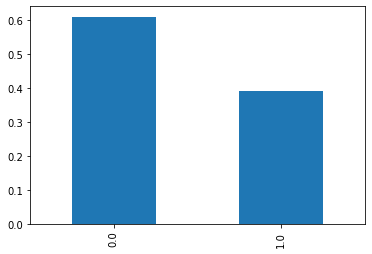

In [129]:
CatBoost_upsampled =  CatBoost =  CatBoostClassifier(logging_level='Silent')
CatBoost_upsampled.fit(X_upsampled, y_upsampled)

# Предскзания
predicted_test = pd.Series(CatBoost_upsampled.predict(X_test))

# Оценка частоты классов для прогноза
class_frequency_model = predicted_test.value_counts(normalize = True) 


print(class_frequency_model)

class_frequency_model.plot(kind = 'bar')

In [130]:
test_predictions_proba = CatBoost_upsampled.predict_proba(X_test)[:, 1]
test_roc_auc_proba = roc_auc_score(y_test, test_predictions_proba)
# Значения метрики качество модели при выбоаной модели
print('Accuracy score CatBoost с апсемплингом',accuracy_score(y_test, predicted_test))
print('')
print('F1 score CatBoost с апсемплингом', f1_score(y_test, predicted_test))
print('')
print('Точность (precision) tp / (tp + fp), доля правильных ответов, действительно являющаяся такой,  для CatBoost', precision_score(y_test, predicted_test))
print('')
print('Полнота (recall) tp / (tp + fn), доля найденных положительных среди всех ответов для CatBoost', recall_score(y_test, predicted_test))
print('')
print('Roc_auc score CatBoost с апсемплингом, на тесте',roc_auc_score(y_test, predicted_test))
print('')
print('Roc_auc score CatBoost с апсемплингом, на тесте для предсказания вероятностей', test_roc_auc_proba)

Accuracy score CatBoost с апсемплингом 0.7707594038325053

F1 score CatBoost с апсемплингом 0.6530612244897959

Точность (precision) tp / (tp + fp), доля правильных ответов, действительно являющаяся такой,  для CatBoost 0.5527272727272727

Полнота (recall) tp / (tp + fn), доля найденных положительных среди всех ответов для CatBoost 0.7979002624671916

Roc_auc score CatBoost с апсемплингом, на тесте 0.779300325786125

Roc_auc score CatBoost с апсемплингом, на тесте для предсказания вероятностей 0.8696498054474708


Метрики качества accuracy, Roc_auc, F1 оптимальны у прогнозов CatBoost на тестовой выборке. Соотношение классов в предсказаниях оптимальное.

Модель находит 80% положительных ответов и упускает только 20%, но при этом достаточно часто (в 45% случаев) выбирает лишние ложнополжительные ответы.
Roc_auc score для модели CatBoost с апсемплингом, на тестовой выборке для предсказания вероятностей соответсвует требуемому занчению и составляет 0.87.

Обозначения
* fn - кому не предложили скидку и он ушел

* fp-  клиент, который пока не собирался уходить, которому предложили скидку 

In [131]:
# Константная модель для проверки модели на адекватность, нулевой массив 
zero_constant_prediction_test = pd.Series([0]*len(y_test))

print(accuracy_score(y_test, zero_constant_prediction_test))

len(zero_constant_prediction_test)

0.7295954577714692


1409

In [132]:
ones_constant_prediction_test = pd.Series([1]*len(y_test))

print(accuracy_score(y_test, ones_constant_prediction_test))

len(ones_constant_prediction_test)


0.2704045422285309


1409

In [133]:
probabilities_test = CatBoost_upsampled.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
probabilities_zero_test = probabilities_test[:, 0]

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'ROC-кривая')

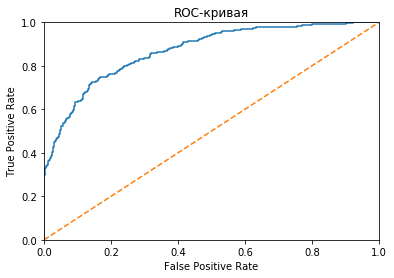

0.8696498054474708


<Figure size 432x432 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

(0.0, 1.05)

(0.0, 1.05)

Text(0.5, 1.0, 'Кривая Precision-Recall')

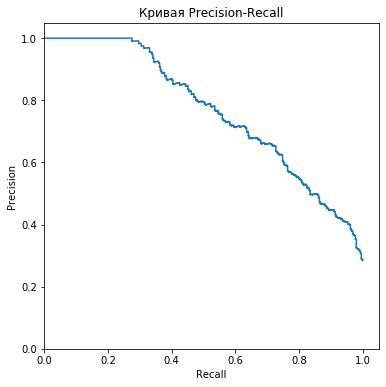

In [134]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая')
plt.show()

auc_roc =  roc_auc_score(y_test, probabilities_one_test)

print(auc_roc)


fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Кривая Precision-Recall')
plt.show()


На Precision Recall кривой (PR-кривой) по оси y - значение точности, по оси x — значение полноты при выбранном пороге.

Чем выше кривая, тем лучше модель. В данном случае кривая достаточно отличается от случайного результата.

In [135]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

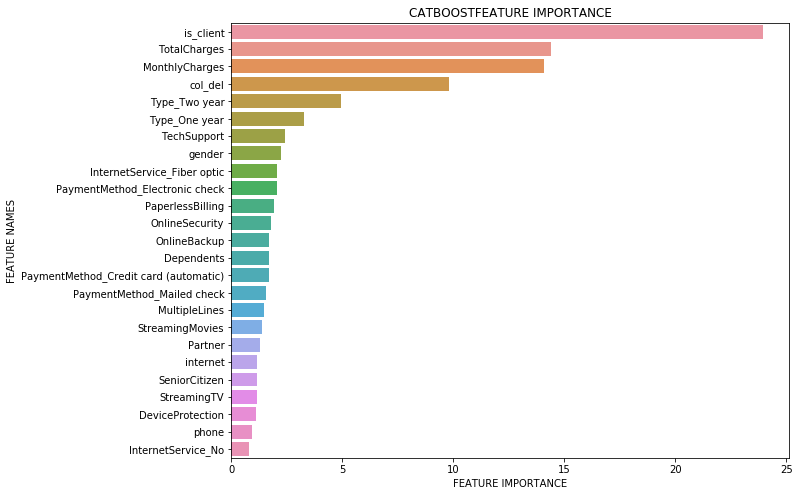

In [136]:
#plot the catboost result
plot_feature_importance(CatBoost_upsampled.get_feature_importance(),X_train.columns,'CATBOOST')

Пример функции для добавления категории
```python
telcom['month_charge_category'] = telcom ['MonthlyCharges']
def list_month1(df):
    return df.assign(month_charge_category=['1' if x == 'Yes' or x == 'No' else '0' for x in df['MultipleLines']])
def list_month2(df):
    return df.assign(month_charge_category=['1' if x == 'Yes' or x == 'No' else '0' for x in df['MultipleLines']])
def list_month(df):
    return df.assign(month_charge_category=['1' if x == 'Yes' or x == 'No' else '0' for x in df['MultipleLines']])

telcom = list_comp_phone(telcom)
telcom 
telcom.query('phone == "1"')
```

## Вывод

Наилучшие метрики accuracy и auc_roc показали модели CatBoostClassifier и adaBoost_model.

Так как auc_roc все же лучше у CatBoostClassifier, то именно её качество проверили на тестовой выборке. 

У модели CatBoost значение accuracy 0.78 на тестовой и 0.85 на валидационной, 0, 87 для вероятностей, это выше , чем 0.73 у константной нулевой модели на 0.05, 0.12, 0.14 соответственно. 

По сравнению с константной моделью с единицами (с метрикой accuracy 0.27) качество еще выше. 
(разница результатов accuracy у константной модели с единицами и нулями вероятно связана с тем, что есть небольшой дисбаланс классов в таргете).

Модель адекватна и может быть использована для прогноза ухода клиентов.

Соотношение классов в предсказаниях CatBoost оптимальное.



Обсуждение.
Для более точного прогноза необходимы еще дополнительные сведения (например, данные о предоствлении тестовых периодом пользователям и их реакции на него, данные о проблемах в работе сервиса и удовлетворенности клиентов работой службы поддержки)? также полезными могли бы быть:
- анализ корреляций именно нулевых платежей с датой регистрации, возможно в какие-то даты проходили акции бесплатного тестового периода  или если есть корреляции с способами оплаты, возможно у кого-то были сложности с оплатой каким-то способом, 
- анализ данных об использованном трафике
-анализ отдельно клиентов с абонплатой и другими фиксированными платежами и др.
- возможна категоризация по размеру месячного платежа,
а)по типу платы(фиксированный или по трафику)
б)по размеру платежа в сравнении с медианой или средним: больше / меньше среднего на 10, 20, 30 процентов 

- оценка с учетом уровеня дохода среднего в городе (если такой удастся найти для нужных лет в другой базе) и т.д.
- можно рекомендовать сделать анализ отдельно для организаций и отдельно физ лиц.



## Отчет

Подготовленный план был выполнен полностью:
- данные загруженны, первичный анализ и предобработка сделаны (в том числе обработка пропусков, изменение типов данных, проверка на дубликаты);

- проведен исследовательский анализ данных: статистический анализ данных, кодировка категориальных признаков, оценка корреляции и мультиколенарности колличественных признаков, 

- построены графики для признаков и отдельно для признака ухода клиента, 

- произведена подготовка данных к обучению (масштабирование признаков, балансировка классов upsampling), 

- выбрана модель, произведен подбор гиперпараметров на валидационной выборке, 

- модель проверена на тестовой выборке.


### Какие трудности возникли и как решены

1. В ходе работы над проектом возникли некоторые вопросы:

1) в таблице contract, какая информация в столбце type (способ оплаты или срок договора или что-то другое), в таблице internet, что в столбце DeviceProtection, в таблице personal для чего столбец Dependents. Также был вопрос по преобразованию типов данных.

2. Было много графиков и сложно было описать с точным указанием нужны чисел. 
Добавила много полуавтоматизированного описания с генерацией текста с подстановкой чисел из расчетов.

3. Попробовала анализировать группы, чтобы сделать handmade тюнинг и потренироваться делать какие-то предположения которые могут быть полезны для бизнес процессов, формулировала необходимые доп вопросы по данным, которые могут улучшить прогноз в будущем, т.е. пробовала делать анализ не только для конкретной метрики.

4. Было много повторяющихся по сути графиков, чтобы не дублировать использовала функции построения графиков.

5. Для работы с подбором гиперпараметров и lgbm не хватало вычислительной мощности, пробовала работать в Google Colab и исключать повторный запуск некоторых "долгих" ячеек, использовала в резуьтате Catboost.

6. Так как в таблице нет дней, а их число высчитывается логически по алгоритму автоматом по количеству дней в фигурирующих месяцах, , было решено считать время "жизни" в днях. Поэтому как вариант этот показатель посчитан в месяцах в столбце 'is_client', но при обучении каждой из моделей для избежания мультиколинеарности былт использован только один из вариантов. 

7.Также была возможна утечка таргета за счет производнхы дат в трейне, поэтому перед обучением необходимо было удалить будет столбцы Begin_year, Begin_month, End_month, EndDate BeginDate.

Также как дополнительный вариант по набору признаков можно бужет проанализировать целесообразность использования в трейне датафрейма без TotalCharges.



### Ключевые шаги в решении задачи 

1. Правильно соединить и обработать таблицы
2. Создать столбец для целевого признака.
3. Выбрать лучшую модель и гиперпараметры
4. Протестировать лучшую модель с лучшими гиперпараметрами. 


### Итоговая модель и её качество

Выбрана модель CatBoost.
Roc AUC для predict_proba()  - 0,87.

Accuracy score CatBoost с апсемплингом 0.7707594038325053

F1 score CatBoost с апсемплингом 0.6530612244897959

Точность (precision) tp / (tp + fp), доля правильных ответов, действительно являющаяся такой,  для CatBoost 0.5527272727272727

Полнота (recall) tp / (tp + fn), доля найденных положительных среди всех ответов для CatBoost 0.7979002624671916

Roc_auc score CatBoost с апсемплингом, на тесте 0.779300325786125

Roc_auc score CatBoost с апсемплингом, на тесте для предсказания вероятностей 0.8696498054474708
Метрики качества accuracy, Roc_auc, F1 оптимальны у прогнозов CatBoost на тестовой выборке. Соотношение классов в предсказаниях оптимальное.

Модель находит 80% положительных ответов и упускает только 20%, но при этом достаточно часто (в 45% случаев) выбирает лишние ложнополжительные ответы. Roc_auc score для модели CatBoost с апсемплингом, на тестовой выборке для предсказания вероятностей соответсвует требуемому занчению и составляет 0.87.

### Обсуждение

Удалось заметить интересные группы клиентов, наиболее склонные к уходу, например, недавно подключившиеся интернет пользователи с помесячным договором и без автоплатежей. 

При глубоком анализе клиентов с DSL подключением появилось предположение, что в целом среди клиентов с DSL много старых лояльных клиентов. Но новые клиенты с помесячным договором и/или даже низкими платежами менее лояльны. 

Интересно было бы оценить целесообразность другого подхода к этим клиентам, проанализировать стоит ли продолжать делать такие подключения новых клиентов. Возможно качество настолько неудобовримое, что нужно предлагать не скидки и акции, а изначально предлагать другой сервис некоторым группам клиентов. 


Как варинт продолжения анализа можно спользовать находки по признакам нелояльных клиентов одним из вариантов:

а)так как у константной модели был хороший результат, то я подумала как вариант взять её за основу и с помощью функции на основании сочетаний неблагоприятных признаков вручную заполнить столбец с предсказаниями для наиболее склонных к уходу клиентов на единицы

б)использовать самый удачный бустинг и для него сделать ручные подстановки в некоторых строках принудительно, только для некоторых строк, самых склонных к уходу клиентов или наоброт тех которые скорее всего останутся (например, с высоким временем лояльности, договором на год и автоплатежами)

в)просто создать на основании находок сочетаний признаков еще признаки (например, старый клиент с низкими платежами - "0",
DSL и помесячный договор и низкое время лояльности - "1")?

А затем  сравнить метрики этих трех вариантов с обычной метрикой просто лучшего бустинга.
Также можно добавить кластеризацию, особенно для каких-то интересных групп отдельно.

Некоторые важные особенности данных:

1.Выявлены аномалии по некоторым месяцам в 2019 году, среди подключившихся в эти месяцы все клиенты были ушедшими. Я решила попробовать удалить все строки подключившихся за эти несколько месяцев, и альтернативно обучить модель без этих данных, сравнить метрики.
Сгенеренные для этого лишние столбцы с производными дат удалить перед обучением.
 
2.Еще были некоторые сложно интерпретируемые наблюдения :
например оказалось, что было всего 5 вариантов месяцев, в которые выбивали клиенты (осень, зима); 

3. Когда я решила сделать таблицу и отдельно посмотреть, какие платежи у пользователей с фиброволокном выбывших, у меня получилась, что на каждые 5 единиц есть свой пик, общая картина складывается как бы из множества графиков с нормальным распределением, учитывая что данные не синтетическиие пыталась как-то анализировать это, но на практический выход по метрикм не все удалось вывести пока.

Добавила проверку гипотез для сравнения по некоторым признакам, но не для всех, сделала например для месячных платежей.
Делала с проверкой дисперсии, не успевала вручную для всех поверить. 